In [5]:
import pandas as pd
import xml.etree.ElementTree as ET
from pathlib import Path
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from zipfile import ZipFile
import numpy as np
from tqdm import tqdm

import matplotlib

%config Completer.use_jedi = False
%env PBR_VERSION=1.2.3

env: PBR_VERSION=1.2.3


# Functions

In [6]:
# Function to convert a SUMO detector output XML file to a pandas DataFrame

def xml_to_dataframe_from_zip(zip_file_path, xml_file_name_inside_zip):
    # Open the ZIP file
    with ZipFile(zip_file_path, 'r') as zip_ref:
        # Open the XML file within the ZIP
        with zip_ref.open(xml_file_name_inside_zip) as xml_file:
            # Parse the XML file
            tree = ET.parse(xml_file)
            root = tree.getroot()
        
            # Initialize an empty list to hold the data
            data = []
        
            # Extract data from each interval element
            for interval in root.findall('.//interval'):
                record = {
                    'begin': interval.get('begin'),
                    'end': interval.get('end'),
                    'id': interval.get('id'),
                    'nVehContrib': interval.get('nVehContrib'),
                    'flow': interval.get('flow'),
                    'occupancy': interval.get('occupancy'),
                    'speed': interval.get('speed'),
                    'harmonicMeanSpeed': interval.get('harmonicMeanSpeed'),
                    'length': interval.get('length'),
                    'nVehEntered': interval.get('nVehEntered')
                }
                data.append(record)
        
            # Convert the list of dictionaries into a DataFrame
            df = pd.DataFrame(data)
        
            # Convert numeric columns from strings to appropriate types
            numeric_cols = ['begin', 'end', 'nVehContrib', 'flow', 'occupancy', 'speed', 'harmonicMeanSpeed', 'length',
                            'nVehEntered']
            df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)
        
            return df

## Strip Changes

In [7]:
def get_strip_changes(zip_file_path, rel_path):
    with ZipFile(zip_file_path, 'r') as zip_ref:
        # Open the XML file within the ZIP
        with zip_ref.open(rel_path) as file_path:
            df = pd.read_csv(file_path)
            count_df = df.groupby(pd.cut(df["Time"], bins=range(0, 4001, 60))).count()["Vehicle"].reset_index()
            # count_df = df.groupby("Time").count()["Vehicle"].reset_index()
            final_val = count_df.iloc[-2]["Vehicle"]
            mean_val = count_df["Vehicle"].mean()
            return final_val, mean_val

In [8]:
def get_collisions_count(zip_file_path, rel_path):
    with ZipFile(zip_file_path, 'r') as zip_ref:
        with zip_ref.open(rel_path) as file_path:
            df = pd.read_csv(file_path)
            return len(df)

## Lateral Change Rate

In [9]:
def get_trajectory_df(zip_file, scenario_name):
    rel_path_tj = zip_file.stem + "/" + scenario_name + "/trajectory.csv"
    rel_path_info = zip_file.stem + "/" + scenario_name + "/vehicle_info.csv"
    with ZipFile(zip_file, 'r') as zip_ref:
        with zip_ref.open(rel_path_tj) as file_path:
            traj_df = pd.read_csv(file_path)
        with zip_ref.open(rel_path_info) as file_path:
            info_df = pd.read_csv(file_path)
    return traj_df, info_df

In [10]:
def calculate_lat_changes(trajectory_df):
    diff_df = trajectory_df.set_index(["Time", "Vehicle1"])
    diff_df = diff_df.groupby(level='Vehicle1')['y'].diff()
    # apply abs to the diff_df
    diff_df = diff_df.abs()
    diff_df = diff_df.groupby(level='Vehicle1').sum() #/ 4000 * 60
    diff_df = diff_df.reset_index()
    diff_df["is_AV"] = diff_df["Vehicle1"].apply(lambda x: list(x.split("_"))[0] == "AV")
    veh_count = len(diff_df["Vehicle1"].unique())
    human_rate = diff_df[diff_df["is_AV"] == False]["y"].sum()
    av_rate = diff_df[diff_df["is_AV"] == True]["y"].sum()
    return human_rate, av_rate, diff_df

def cal_lateral_speed(trajectory_df):
    trajectory_df["avg_speed_y"] = trajectory_df["speed_y"].abs()
    veh_avg = trajectory_df.groupby("Vehicle1")["avg_speed_y"].mean().reset_index()
    veh_avg["is_AV"] = veh_avg["Vehicle1"].apply(lambda x: list(x.split("_"))[0] == "AV")
    human = veh_avg[veh_avg["is_AV"] == False]["avg_speed_y"].mean()
    av = veh_avg[veh_avg["is_AV"] == True]["avg_speed_y"].mean()
    return human, av

def add_lateral_change_rate(df):
    h_list = []
    av_list = []
    h_lats = []
    av_lats = []
    for _, row in tqdm(list(df.iterrows())):
        trajectory_df, _ = get_trajectory_df(row["zip_file"], row["scenario_name"])
        human_rate, av_rate, _ = calculate_lat_changes(trajectory_df)
        human_lat, av_lat = cal_lateral_speed(trajectory_df)
        h_list.append(human_rate)
        av_list.append(av_rate)
        h_lats.append(human_lat)
        av_lats.append(av_lat)
    df["Lateral Change Human"] = h_list
    df["Lateral Change AV"] = av_list
    df["Lateral Change Total"] = df["Lateral Change Human"] + df["Lateral Change AV"]
    df["Human Lat Speed"] = h_lats
    df["AV Lat Speed"] = av_lats
    return df

## Space and Time Gap

In [11]:
def calculate_lateral_stats(df, xlim, ylims, time_accumulate=True):
    # Calculate the difference between consecutive 'x' values for each vehicle
    df['x_diff'] = df.groupby('Vehicle1')['x'].diff()
    # Identify the rows where 'x_diff' is negative (indicating a rotation)
    df['rotation_flag'] = df['x_diff'] < 0
    # Calculate the cumulative sum of rotation flags for each vehicle
    df['rounds_of_rotation'] = df.groupby('Vehicle1')['rotation_flag'].cumsum()
    # Drop the intermediate columns
    df.drop(columns=['x_diff', 'rotation_flag'], inplace=True)
    
    df_consider = df[(df['x'] > xlim[0]) & (df['x'] < xlim[1]) & (df['rounds_of_rotation'] > 0)].copy()
    # Sort by time to get the order in which they cross x=340
    df_consider = df_consider.sort_values(by='Time')
    
    # Drop duplicates to count each vehicle only once per round of rotation
    df_consider = df_consider.drop_duplicates(subset=['Vehicle1', 'rounds_of_rotation'])
    if time_accumulate is False:
        return df_consider
    
    stats = defaultdict(list)
    for ylim in ylims:
        df_y = df_consider[(df_consider["y"] >= ylim[0]) & (df_consider["y"] < ylim[1])].copy()
        df_y['time_gap'] = df_y['Time'].diff()
        df_y['time_gap'] = df_y['time_gap'] - (df_y['x'] - xlim[0]) / df_y['speed_x']
        df_y['space_gap'] = df_y['time_gap'] * df_y['speed_x']
        
        stats["y"].append(ylim[0])
        stats["time_gap"].append(df_y["time_gap"].mean())
        stats["space_gap"].append(df_y["space_gap"].mean())
        stats["mean_speed_x"].append(df_y["speed_x"].mean())
    return pd.DataFrame(stats)

def add_space_time_gap(scenario_df):
    stats = defaultdict(list)
    for _, row in tqdm(list(scenario_df.iterrows())):
        df = get_trajectory_df(row["zip_file"], row["scenario_name"])
        stats_df = calculate_lateral_stats(df, (340, 360), [(0, 1.9), (8.3, 10.2)])
        for _, row_2 in stats_df.iterrows():
            stats["space_gap_" + str(row_2["y"])].append(row_2["space_gap"])
            stats["time_gap_" + str(row_2["y"])].append(row_2["time_gap"])
            stats["mean_speed_x_" + str(row_2["y"])].append(row_2["mean_speed_x"])
    for key, value in stats.items():
        scenario_df[key] = value
    return scenario_df

## Overall Function

In [12]:
def read_csv_config(csv_scene_file, addstrip_changes=True):
    df = pd.read_csv(csv_scene_file)
    experiment_name = Path(csv_scene_file).stem
    zip_file = Path(csv_scene_file).parent.joinpath(experiment_name + ".zip")
    results_folder = Path(csv_scene_file).parent.joinpath(experiment_name)
    results = defaultdict(list)
    for _, row in tqdm(list(df.iterrows())):
        scenario_name = row['scenario_name']
        # detector_file = results_folder.joinpath(scenario_name, 'detector_1.xml')
        detector_file = zip_file.stem + "/" + scenario_name + "/detector_1.xml"
        detector_df = xml_to_dataframe_from_zip(zip_file, detector_file)
        #info = detector_df[detector_df.begin==3600].iloc[0]
        info = detector_df[(detector_df.begin>2000) & (detector_df.begin<=3600)].mean(numeric_only=True)
        results["flow"].append(info['flow'])
        results["speed"].append(info['speed'])
        
        if addstrip_changes is True:
            strips_change_file = zip_file.stem + "/" + scenario_name + "/strips_change.csv"
            final_val, mean_val = get_strip_changes(zip_file, strips_change_file)
            results["Mean Strip Changes"].append(mean_val)
        
        collisions_file = zip_file.stem + "/" + scenario_name + "/collisions_file.csv"
        collisions_count = get_collisions_count(zip_file, collisions_file)
        results["Total Collisions"].append(collisions_count)
        
    for key, value in results.items():
        df[key] = value
    df["Mean Strip Changes per Vehicle"] = df["Mean Strip Changes"]/df["Total Vehicles"]
    df.rename(columns={"Strip Based Human Parameters:LaneChangeThreshold": "Strip Change Threshold"}, inplace=True)
    df.drop(columns=["RANDOM Init:vehicle_types", "RANDOM Init:vehicle_counts", "end_time", "default_config", "config",
                     "sumo_config", "Unnamed: 0"], inplace=True)
    df["zip_file"] = zip_file
    return df

# Read Data

In [9]:
df_human = read_csv_config("SUMO_Runs\\ring_road_single_edge\\Experiments\\human_new.csv")
df_av = read_csv_config("SUMO_Runs\\ring_road_single_edge\\Experiments\\av_only_new.csv")
df_mixed = read_csv_config("SUMO_Runs\\ring_road_single_edge\\Experiments\\mixed_new.csv")

for df in [df_human, df_mixed, df_av]:
    df.rename(columns={"General Parameters:seed": "seed"}, inplace=True)

100%|██████████| 240/240 [00:32<00:00,  7.30it/s]


In [10]:
df_av["Penetration Rate"] = 1.0
df_av["Strip Change Threshold"] = np.nan
df_human["Penetration Rate"] = 0.0

for df in [df_human, df_mixed, df_av]:
    filter_av = df_av.set_index(["Total Vehicles", "seed"]).loc[zip(df["Total Vehicles"].values, df["seed"].values)]
    df["Relative Flow Change"] = 100 * (df["flow"] - filter_av["flow"].values) / filter_av["flow"].values
    df["Relative Speed Change"] = 100 * (df["speed"] - filter_av["speed"].values) / filter_av["speed"].values

In [11]:
df_human.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Strip Change Threshold          120 non-null    float64
 1   seed                            120 non-null    int64  
 2   Total Vehicles                  120 non-null    int64  
 3   Total Humans                    120 non-null    int64  
 4   Total AV                        120 non-null    int64  
 5   scenario_name                   120 non-null    object 
 6   flow                            120 non-null    float64
 7   speed                           120 non-null    float64
 8   Mean Strip Changes              120 non-null    float64
 9   Total Collisions                120 non-null    int64  
 10  Mean Strip Changes per Vehicle  120 non-null    float64
 11  zip_file                        120 non-null    object 
 12  Penetration Rate                120 

# Flow plots

In [93]:
matplotlib.rcParams['text.usetex'] = True

,seed,index,Strip Change Threshold,Total Vehicles,Total Humans,Total AV,Flow (veh/h),Mean Speed (m/s),Mean Strip Changes,Total Collisions,Mean Strip Changes \nper Minute,Penetration Rate,Relative Flow Change,Relative Speed Change,Vehicle Density (veh/km)
0,1,58.5,6.32,225.0,225.0,0.0,6281.5,12.016875,10327.571970,221.775,56.241421,0.0,-52.560862,-50.425964,225.0
1,2,59.5,6.32,225.0,225.0,0.0,6096.0,11.757375,9978.493182,437.450,53.275109,0.0,-54.229059,-51.845788,225.0
2,3,60.5,6.32,225.0,225.0,0.0,6315.7,12.134667,10424.457576,945.025,56.105329,0.0,-50.792477,-48.542858,225.0


## Human Only

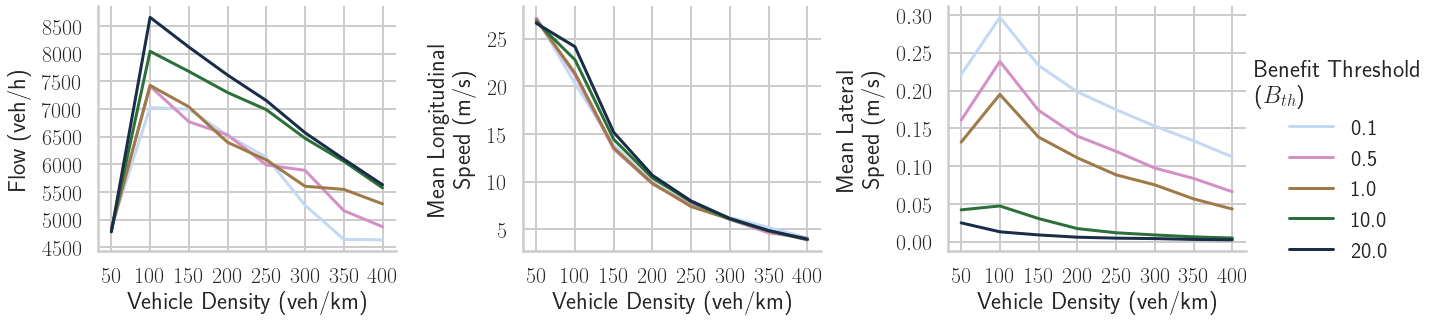

In [47]:
dplot = pd.concat([df_human]).reset_index().copy()
dplot = dplot[dplot["Strip Change Threshold"].isin([0.1, 0.5, 1, 10, 20])]
dplot = dplot[dplot["Penetration Rate"].isin([0])]
dplot["Penetration Rate"] = (dplot["Penetration Rate"]*100).astype(int)
dplot["Vehicle Density (veh/km)"] = dplot["Total Vehicles"]
dplot["Mean Lateral Speed (m/s)"] = 0.1 * dplot["Mean Strip Changes per Vehicle"] / 60
dplot = dplot.groupby(["Vehicle Density (veh/km)", "Penetration Rate", "Strip Change Threshold"]).mean().reset_index()

base_vars = ["Vehicle Density (veh/km)", "Penetration Rate", "Strip Change Threshold"]
plot_names = {"flow": "Flow (veh/h)", "speed": "Mean Longitudinal\n Speed (m/s)", 
              # "Mean Strip Changes per Vehicle": "Mean Strip Changes \nper Minute"
              "Mean Lateral Speed (m/s)": "Mean Lateral\n Speed (m/s)"
              }
dplot.rename(columns=plot_names, inplace=True)
plot_vars = list(plot_names.values())
facet_data = pd.melt(dplot, id_vars=base_vars, value_vars=plot_vars)

with sns.axes_style("whitegrid", {'axes.grid' : True}):
    with sns.plotting_context("poster", font_scale=1):
        custom_palette = sns.color_palette("cubehelix_r", n_colors=len(dplot["Strip Change Threshold"].unique()))
        
        facet = sns.FacetGrid(facet_data, col="variable", col_wrap=3, sharey=False, sharex=False, aspect=1.2, height=5, margin_titles=True, 
                              legend_out=True,
                              # hue_kws=d, hue="Method_p", hue_order=hue_order
                             )
        facet.map_dataframe(sns.lineplot, "Vehicle Density (veh/km)", "value", hue="Strip Change Threshold", palette=custom_palette)
        facet.set_titles(col_template = "")
        for ax, col in zip(facet.axes.flatten(), plot_vars):
            ax.set_ylabel(col, labelpad=11)
        plt.tight_layout()
        facet.add_legend(title="Benefit Threshold \n($B_{th}$)")
# plt.savefig("trb_figures\\flow_human.pdf", bbox_inches='tight')

## Mixed

In [19]:
dplot = pd.concat([df_mixed, df_av, df_human]).reset_index()
dplot = dplot[dplot["Strip Change Threshold"].isin([np.nan, 10])]
# dplot = dplot[dplot["Penetration Rate"].isin([0, 1, 0.1, 0.5, 0.9, 0.95, 0.99])]
dplot["Human Penetration Rate"] = (100 - 100 * dplot["Penetration Rate"]).astype(int)
dplot["Vehicle Density (veh/km)"] = dplot["Total Vehicles"]

dplot = add_lateral_change_rate(dplot)

100%|██████████| 288/288 [47:01<00:00,  9.80s/it] 


In [21]:
# dplot.to_pickle("trb_figures\\mixed_df_1_new.pkl")

In [20]:
dplot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 0 to 380
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           288 non-null    int64  
 1   Penetration Rate                288 non-null    float64
 2   Total Vehicles                  288 non-null    int64  
 3   Strip Change Threshold          264 non-null    float64
 4   seed                            288 non-null    int64  
 5   Total Humans                    288 non-null    int64  
 6   Total AV                        288 non-null    int64  
 7   scenario_name                   288 non-null    object 
 8   flow                            288 non-null    float64
 9   speed                           288 non-null    float64
 10  Mean Strip Changes              288 non-null    float64
 11  Total Collisions                288 non-null    int64  
 12  Mean Strip Changes per Vehicle  288 

In [50]:
dplot = pd.read_pickle("trb_figures\\mixed_df_1_new.pkl")
dplot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 0 to 380
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           288 non-null    int64  
 1   Penetration Rate                288 non-null    float64
 2   Total Vehicles                  288 non-null    int64  
 3   Strip Change Threshold          264 non-null    float64
 4   seed                            288 non-null    int64  
 5   Total Humans                    288 non-null    int64  
 6   Total AV                        288 non-null    int64  
 7   scenario_name                   288 non-null    object 
 8   flow                            288 non-null    float64
 9   speed                           288 non-null    float64
 10  Mean Strip Changes              288 non-null    float64
 11  Total Collisions                288 non-null    int64  
 12  Mean Strip Changes per Vehicle  288 

In [51]:
dplot.to_csv("trb_figures\\mixed_df_1_new.csv")

In [56]:
df.groupby(["Penetration Rate"]).mean().reset_index()

,Penetration Rate,index,Total Vehicles,Strip Change Threshold,seed,Total Humans,Total AV,Flow (veh/h),Mean Speed (m/s),Mean Strip Changes,...,Mean Strip Changes per Vehicle,Relative Flow Change,Relative Speed Change,Human Penetration Rate,Vehicle Density (veh/km),Lateral Change Human,Lateral Change AV,Lateral Change Total,Mean Lateral Change Human,Mean Lateral Change AV
0,0.00,62.5,225.0,10.0,2.0,225.0,0.0,6613.250000,12.144236,1863.738636,...,12.747447,-50.269582,-49.648263,100.0,225.0,4729.195000,0.000000,4729.195000,0.486826,NaN
1,0.10,11.5,225.0,10.0,2.0,202.5,22.5,6688.250000,12.199167,1770.870581,...,12.156939,-49.929179,-49.281373,90.0,225.0,4493.672917,4250.011667,8743.684583,0.515649,4.640837
2,0.50,83.5,225.0,10.0,2.0,112.5,112.5,7554.000000,13.803889,1161.721591,...,7.068645,-44.292791,-41.988520,50.0,225.0,2962.603750,29345.243750,32307.847500,0.540184,0.540184
3,0.90,155.5,225.0,10.0,2.0,22.5,202.5,11745.416667,18.512014,96.175505,...,0.609793,-20.681506,-18.804227,10.0,225.0,243.060417,39137.741250,39380.801667,0.231101,0.025678
4,0.95,179.5,225.0,10.0,2.0,11.5,213.5,13337.250000,19.811389,26.944444,...,0.188093,-12.520368,-11.736454,5.0,225.0,68.247917,30285.377917,30353.625833,0.132562,0.007486
5,0.99,227.5,225.0,10.0,2.0,2.5,222.5,15029.083333,21.562083,6.804924,...,0.079373,-2.816277,-2.746925,1.0,225.0,17.454167,14884.762917,14902.217083,0.190511,0.003117
6,1.00,11.5,225.0,NaN,2.0,0.0,225.0,15503.750000,22.147639,0.000000,...,0.000000,0.000000,0.000000,0.0,225.0,0.000000,9987.990000,9987.990000,NaN,0.000000


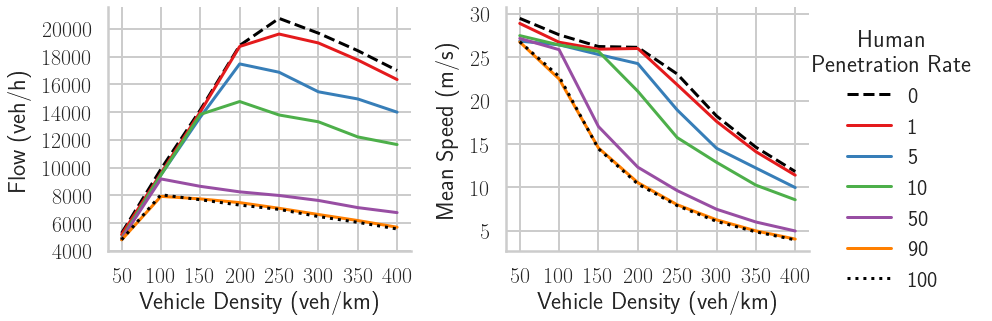

In [76]:
df = dplot.copy()
df = df[df["Penetration Rate"].isin([0, 1, 0.1, 0.5, 0.9, 0.95, 0.99])]
df["Mean Lateral Change Human"] = df["Lateral Change Human"] / df["Total Humans"] / 4000 * 60
df["Mean Lateral Change AV"] = df["Lateral Change Human"] / df["Total AV"] / 4000 * 60
df.loc[df["Human Penetration Rate"] == 0, "Strip Change Threshold"] = 10
df = df.groupby(["Human Penetration Rate", "Vehicle Density (veh/km)", "Strip Change Threshold"]).mean().reset_index()

base_vars = ["Vehicle Density (veh/km)", "Human Penetration Rate", "Penetration Rate", "Strip Change Threshold"]
plot_names = {"flow": "Flow (veh/h)", "speed": "Mean Speed (m/s)", #"Mean Lateral Change AV": "Mean Lateral Change AV", "Mean Lateral Change Human": "Mean Lateral Change Human"
              }
df.rename(columns=plot_names, inplace=True)
plot_vars = list(plot_names.values())
facet_data = pd.melt(df, id_vars=base_vars, value_vars=plot_vars)

with sns.axes_style("whitegrid", {'axes.grid' : True}):
    with sns.plotting_context("poster", font_scale=1):
        custom_palette = sns.color_palette("Set1", n_colors=len(df["Human Penetration Rate"].unique()))
        d = {'color': [(0,0,0)] + custom_palette[0:-2] + [(0,0,0)], "ls" : ["--"] + ["-"]*5 + [":"]}
        
        facet = sns.FacetGrid(facet_data, col="variable", col_wrap=2, sharey=False, sharex=False, aspect=1.2, height=5, margin_titles=True, 
                              legend_out=True, hue_kws=d, hue="Human Penetration Rate"
                             )
        facet.map_dataframe(sns.lineplot, "Vehicle Density (veh/km)", "value", #hue="Human Penetration Rate", 
                            # palette=custom_palette
                            )
        facet.set_titles(col_template = "")
        for ax, col in zip(facet.axes.flatten(), plot_vars):
            ax.set_ylabel(col, labelpad=11)
        plt.tight_layout()
        facet.add_legend(title="Human\n Penetration Rate")
        plt.setp(facet._legend.get_title(), ha='center')
# plt.savefig("trb_figures\\flow_speed_mixed.pdf", bbox_inches='tight')

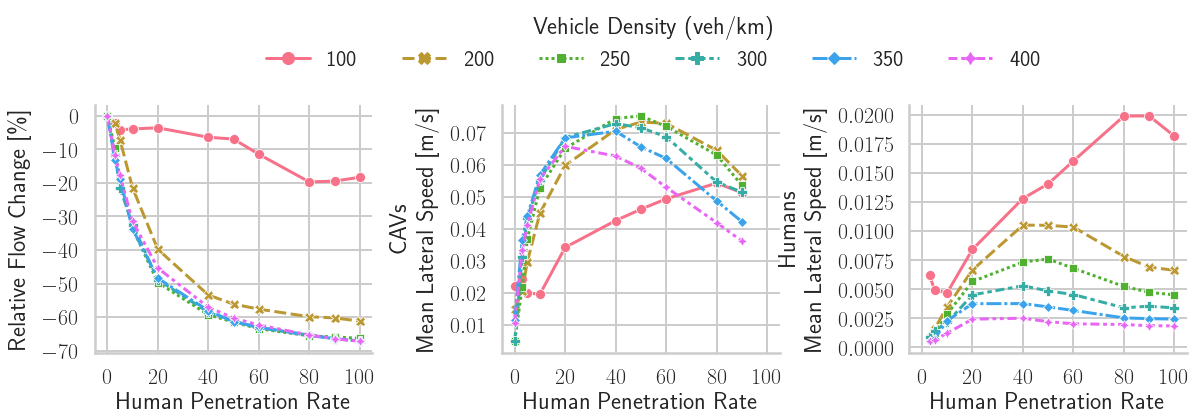

In [25]:
df = dplot.copy()
df = df[df["Penetration Rate"].isin([0, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 0.9, 0.95, 0.97, 1])]
df["Mean Lateral Change Human"] = df["Lateral Change Human"] / df["Total Humans"] / 4000
df["Mean Lateral Change AV"] = df["Lateral Change AV"] / df["Total AV"] / 4000


df.loc[df["Human Penetration Rate"] == 0, "Strip Change Threshold"] = 10
df = df.groupby(["Human Penetration Rate", "Vehicle Density (veh/km)", "Strip Change Threshold"]).mean().reset_index()

base_vars = ["Vehicle Density (veh/km)", "Human Penetration Rate", "Strip Change Threshold"]
plot_names = {"Relative Flow Change": "Relative Flow Change [\%]", 
              # "Relative Speed Change": "Relative Speed Change [\%]", 
              "AV Lat Speed": "CAVs \n Mean Lateral Speed [m/s]", 
              "Human Lat Speed": "Humans \n Mean Lateral Speed [m/s]"}
df.rename(columns=plot_names, inplace=True)
plot_vars = list(plot_names.values())
facet_data = pd.melt(df, id_vars=base_vars, value_vars=plot_vars)
facet_data = facet_data[facet_data["Vehicle Density (veh/km)"].isin([100, 200, 250, 300, 350, 400])]

with sns.axes_style("whitegrid", {'axes.grid' : True}):
    with sns.plotting_context("poster", font_scale=1):
        custom_palette = sns.color_palette("husl", 6)
        d = {'color': custom_palette}
        
        facet = sns.FacetGrid(facet_data, col="variable", col_wrap=3, sharey=False, sharex=False, aspect=1.2, height=5, margin_titles=True, 
                              legend_out=True, xlim=(-5,105)  #hue_kws=d, hue="Vehicle Density (veh/km)", xlim=(-0.5, 100),
                             )
        facet.map_dataframe(sns.lineplot, "Human Penetration Rate", "value", hue="Vehicle Density (veh/km)", 
                            style="Vehicle Density (veh/km)", markers=True, palette=custom_palette, markersize=10
                            )
        facet.set_titles(col_template = "")
        for ax, col in zip(facet.axes.flatten(), plot_vars):
            ax.set_ylabel(col, labelpad=11)
        plt.tight_layout()
        facet.add_legend(title="Vehicle Density (veh/km)", ncol=6, bbox_to_anchor=(0.55, 1.1))
        plt.setp(facet._legend.get_title(), ha='center')
# plt.savefig("trb_figures\\rel_flow_speed_mixed.pdf", bbox_inches='tight')

## Space and Time Gap

In [12]:
dplot = add_space_time_gap(dplot)

100%|██████████| 160/160 [15:46<00:00,  5.92s/it]


In [116]:
#dplot.to_pickle("trb_figures\\mixed_df_2.pkl")
dplot = pd.read_pickle("trb_figures\\mixed_df_2.pkl")
dplot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 2 to 495
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           160 non-null    int64  
 1   Penetration Rate                160 non-null    float64
 2   Total Vehicles                  160 non-null    float64
 3   Strip Change Threshold          152 non-null    float64
 4   Total Humans                    160 non-null    float64
 5   Total AV                        160 non-null    float64
 6   scenario_name                   160 non-null    object 
 7   flow                            160 non-null    float64
 8   speed                           160 non-null    float64
 9   Mean Strip Changes              160 non-null    float64
 10  Total Collisions                160 non-null    int64  
 11  Mean Strip Changes per Vehicle  160 non-null    float64
 12  zip_file                        160 

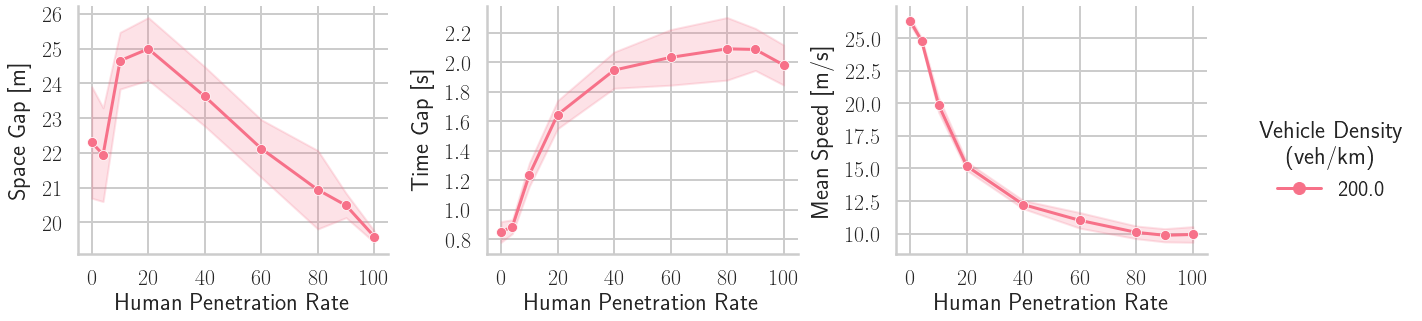

In [126]:
df = dplot.copy()
df = df[df["Penetration Rate"].isin([0, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.96, 1])]
df["Mean Lateral Change Human"] = df["Lateral Change Human"] / df["Total Humans"] / 4000 * 60
df["Mean Lateral Change AV"] = df["Lateral Change AV"] / df["Total AV"] / 4000 * 60

base_vars = ["Vehicle Density (veh/km)", "Human Penetration Rate", "Strip Change Threshold"]
plot_names = {f"space_gap": "Space Gap [m]", 
              f"time_gap": "Time Gap [s]", 
              f"mean_speed_x": "Mean Speed [m/s]",
              }
plot_names_y = {}
plot_vars = []
for y in [0.0, 8.3]:
    for x in ["space_gap", "time_gap", "mean_speed_x"]:
        plot_vars.append(f"{x}_{y}")
        plot_names_y[f"{x}_{y}"] = plot_names[x]
facet_data = pd.melt(df, id_vars=base_vars, value_vars=plot_vars)
facet_data["y"] = facet_data["variable"].apply(lambda x: float(x.split("_")[-1]))
facet_data["variable_2"] = facet_data["variable"].apply(lambda x: plot_names_y[x])

plot_vars = list(plot_names.values())
facet_data = facet_data[facet_data["Vehicle Density (veh/km)"].isin([200])]

with sns.axes_style("whitegrid", {'axes.grid' : True}):
    with sns.plotting_context("poster", font_scale=1):
        custom_palette = sns.color_palette("husl", 1)
        d = {'color': custom_palette}
        
        facet = sns.FacetGrid(facet_data, col="variable_2",  sharey="col", sharex=False, aspect=1.2, height=5, margin_titles=True, 
                              legend_out=True, xlim=(-5,105)  #hue_kws=d, hue="Vehicle Density (veh/km)", xlim=(-0.5, 100),
                             )
        facet.map_dataframe(sns.lineplot, "Human Penetration Rate", "value", hue="Vehicle Density (veh/km)", 
                            style="Vehicle Density (veh/km)", markers=True, palette=custom_palette, markersize=10
                            )
        facet.set_titles(col_template = "")
        for ax, col in zip(facet.axes.flatten(), plot_vars):
            ax.set_ylabel(col, labelpad=11)
        plt.tight_layout()
        facet.add_legend(title="Vehicle Density\n (veh/km)")
        plt.setp(facet._legend.get_title(), ha='center')
# plt.savefig(f"trb_figures\\space_time_gap_fast_lane.pdf", bbox_inches='tight')

## Trajectory Plots

In [10]:
dplot = pd.read_pickle("trb_figures\\mixed_df_1_new.pkl")
dplot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 0 to 380
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           288 non-null    int64  
 1   Penetration Rate                288 non-null    float64
 2   Total Vehicles                  288 non-null    int64  
 3   Strip Change Threshold          264 non-null    float64
 4   seed                            288 non-null    int64  
 5   Total Humans                    288 non-null    int64  
 6   Total AV                        288 non-null    int64  
 7   scenario_name                   288 non-null    object 
 8   flow                            288 non-null    float64
 9   speed                           288 non-null    float64
 10  Mean Strip Changes              288 non-null    float64
 11  Total Collisions                288 non-null    int64  
 12  Mean Strip Changes per Vehicle  288 

In [14]:
dplot = pd.concat([df_mixed, df_av, df_human]).reset_index()
dplot = dplot[dplot["Strip Change Threshold"].isin([np.nan, 10])]
# dplot = dplot[dplot["Penetration Rate"].isin([0, 1, 0.1, 0.5, 0.9, 0.95, 0.99])]
dplot["Human Penetration Rate"] = (100 - 100 * dplot["Penetration Rate"]).astype(int)
dplot["Vehicle Density (veh/km)"] = dplot["Total Vehicles"]

In [292]:
scene_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 2 to 495
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           56 non-null     int64  
 1   Penetration Rate                56 non-null     float64
 2   Total Vehicles                  56 non-null     float64
 3   Strip Change Threshold          48 non-null     float64
 4   Total Humans                    56 non-null     float64
 5   Total AV                        56 non-null     float64
 6   scenario_name                   56 non-null     object 
 7   flow                            56 non-null     float64
 8   speed                           56 non-null     float64
 9   Mean Strip Changes              56 non-null     float64
 10  Total Collisions                56 non-null     int64  
 11  Mean Strip Changes per Vehicle  56 non-null     float64
 12  zip_file                        56 no

In [10]:
scene_df = dplot[(dplot["Total Vehicles"].isin([100, 150, 200, 300, 400])) & (dplot["Human Penetration Rate"].isin([0, 1, 5, 10, 50, 90, 100])) 
              & (dplot["Strip Change Threshold"].isin([np.nan, 10])) & (dplot["seed"] == 1)]

traj_list = []
veh_info_list = []
for _, row in tqdm(list(scene_df.iterrows())):
    tj, info = get_trajectory_df(row["zip_file"], row["scenario_name"])
    tj["Human Penetration Rate"] = row["Human Penetration Rate"]
    tj["Total Vehicles"] = row["Total Vehicles"]
    tj["scenario_name"] = row["scenario_name"]
    tj["seed"] = row["seed"]
    traj_list.append(tj)
    veh_info_list.append(info)
scene_df

 85%|████████▍ | 89/105 [05:19<00:57,  3.59s/it]


MemoryError: Unable to allocate 342. MiB for an array with shape (7, 6399600) and data type float64

In [11]:
def cal_pl_from_speed(desired_speed):
    lower_long = 1.2
    upper_long = 9.0
    min_desired = 25
    max_desired = 35
    area = max_desired - min_desired
    co = desired_speed - min_desired
    return lower_long + ((upper_long - lower_long) / area) * co

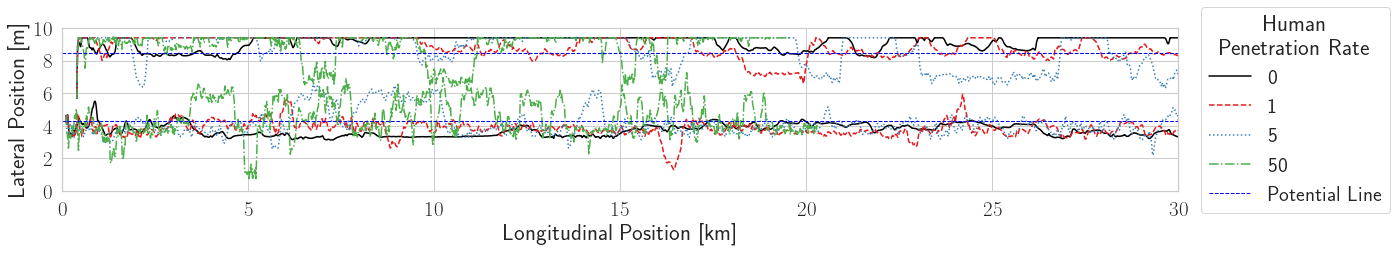

In [30]:
veh_plot = ["AV_1_5", "AV_1_1"]
vehile_count = 400
rates = [0, 1, 5, 50]
plot_seed = 1
ls = ["-", "--", ":", "-."]
colors = ["black"] + sns.color_palette("Set1")[:3]
pl_lines = set()
labels = set()

traj_list.sort(key=lambda x: x["Human Penetration Rate"].iloc[0])
with sns.axes_style("whitegrid", {'axes.grid' : True}):
    with sns.plotting_context("notebook", font_scale=1.9):
        fig, ax = plt.subplots(1,1, figsize=(20,3))
        for traj_df, veh_info in zip(traj_list, veh_info_list):
            pen_rate = traj_df["Human Penetration Rate"].iloc[0]
            vehicles = traj_df["Total Vehicles"].iloc[0]
            seed = traj_df["seed"].iloc[0]
            for veh in veh_plot:
                if pen_rate in rates:
                    if vehicles == vehile_count and seed==plot_seed:
                        pl = cal_pl_from_speed(veh_info[veh_info["Vehicle"] == veh]["desired_speed"].iloc[0])
                        pl_lines.add(pl)
                        veh_traj = traj_df[traj_df["Vehicle1"] == veh].copy()
                        veh_traj['x_diff'] = veh_traj['x'].diff()
                        # Identify the rows where 'x_diff' is negative (indicating a rotation)
                        veh_traj['rotation_flag'] = veh_traj['x_diff'] < 0
                        # Calculate the cumulative sum of rotation flags for each vehicle
                        veh_traj['rounds_of_rotation'] = veh_traj['rotation_flag'].cumsum()
                        veh_traj['x_corrected'] = veh_traj['rounds_of_rotation']*1000 + veh_traj['x']
                        veh_traj['x_corrected'] = veh_traj['x_corrected'] / 1000
                        i = rates.index(pen_rate)
                        ll = str(pen_rate)
                        if ll in labels:
                            ll = None
                        else:
                            labels.add(ll)
                        sns.lineplot(data=veh_traj, x="x_corrected", y="y", ax=ax, label=ll, ls=ls[i], color=colors[i])
                        ax.set_ylim(0, 10)
                        ax.set_xlim(0, 30)
                        ax.set_ylabel("Lateral Position [m]")
                        ax.set_xlabel("Longitudinal Position [km]")
                
        for i, pl in enumerate(pl_lines):
            label = "Potential Line" if i == 0 else None
            ax.axhline(y=pl, color='b', linestyle='--', linewidth=1.0, label=label)
        l = plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0, title="Human\nPenetration Rate")
        plt.setp(l.get_title(), ha='center')
plt.savefig(f"trb_figures\\tranjector_{vehile_count}.pdf", bbox_inches='tight')

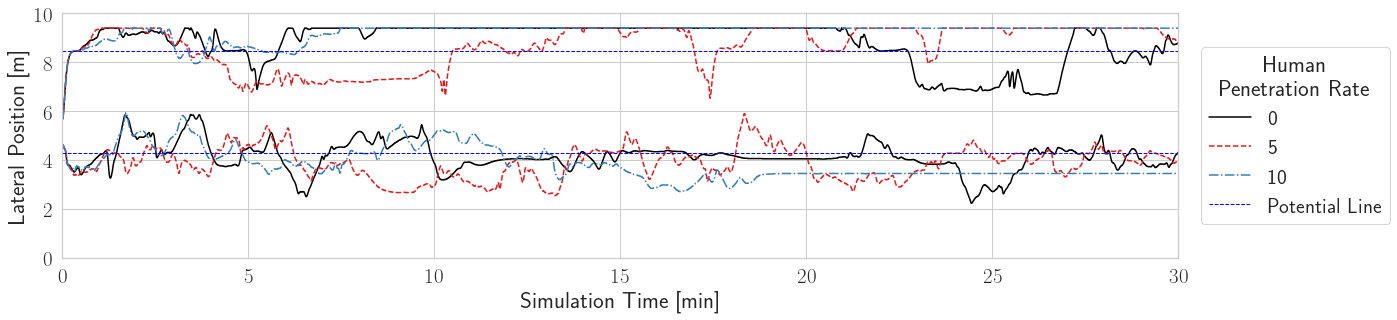

In [61]:
veh_plot = ["AV_1_5", "AV_1_1"]
vehile_count = 100
rates = [0, 5, 10]
plot_seed = 1
ls = ["-", "--", "-.", ":"]
colors = ["black"] + sns.color_palette("Set1")[:3]
pl_lines = set()
labels = set()

traj_list.sort(key=lambda x: x["Human Penetration Rate"].iloc[0])
with sns.axes_style("whitegrid", {'axes.grid' : True}):
    with sns.plotting_context("notebook", font_scale=1.9):
        fig, ax = plt.subplots(1,1, figsize=(20,4.5))
        for traj_df, veh_info in zip(traj_list, veh_info_list):
            pen_rate = traj_df["Human Penetration Rate"].iloc[0]
            vehicles = traj_df["Total Vehicles"].iloc[0]
            seed = traj_df["seed"].iloc[0]
            for veh in veh_plot:
                if pen_rate in rates:
                    if vehicles == vehile_count and seed==plot_seed:
                        pl = cal_pl_from_speed(veh_info[veh_info["Vehicle"] == veh]["desired_speed"].iloc[0])
                        pl_lines.add(pl)
                        veh_traj = traj_df[traj_df["Vehicle1"] == veh].copy()
                        veh_traj['x_diff'] = veh_traj['x'].diff()
                        # Identify the rows where 'x_diff' is negative (indicating a rotation)
                        veh_traj['rotation_flag'] = veh_traj['x_diff'] < 0
                        # Calculate the cumulative sum of rotation flags for each vehicle
                        veh_traj['rounds_of_rotation'] = veh_traj['rotation_flag'].cumsum()
                        veh_traj['x_corrected'] = veh_traj['rounds_of_rotation']*1000 + veh_traj['x']
                        veh_traj['x_corrected'] = veh_traj['x_corrected'] / 1000
                        i = rates.index(pen_rate)
                        ll = str(pen_rate)
                        if ll in labels:
                            ll = None
                        else:
                            labels.add(ll)
                        veh_traj["time_min"] = veh_traj["Time"] / 60
                        sns.lineplot(data=veh_traj, x="time_min", y="y", ax=ax, label=ll, ls=ls[i], color=colors[i])
                        ax.set_ylim(0, 10)
                        ax.set_xlim(0, 30)
                        ax.set_ylabel("Lateral Position [m]")
                        ax.set_xlabel("Simulation Time [min]")
                
        for i, pl in enumerate(pl_lines):
            label = "Potential Line" if i == 0 else None
            ax.axhline(y=pl, color='blue', linestyle='--', linewidth=1.0, label=label)
        l = plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0, title="Human\nPenetration Rate")
        plt.setp(l.get_title(), ha='center')
plt.savefig(f"trb_figures\\tranjector_{vehile_count}.pdf", bbox_inches='tight')

## Logitudinal Speed Heat Plots

In [ ]:
# dplot = pd.concat([df_mixed, df_av, df_human, df_mixed_high_res]).reset_index()
# dplot = dplot[dplot["Strip Change Threshold"].isin([np.nan, 10])]
# # dplot = dplot[dplot["Penetration Rate"].isin([0, 1, 0.1, 0.5, 0.9, 0.95, 0.99])]
# dplot["Human Penetration Rate"] = (100 - 100 * dplot["Penetration Rate"]).astype(int)
# dplot["Vehicle Density (veh/km)"] = dplot["Total Vehicles"]

In [147]:
np.arange(0, 10.3, 2)


array([ 0.,  2.,  4.,  6.,  8., 10.])

100%|██████████| 49/49 [00:04<00:00, 11.06it/s]


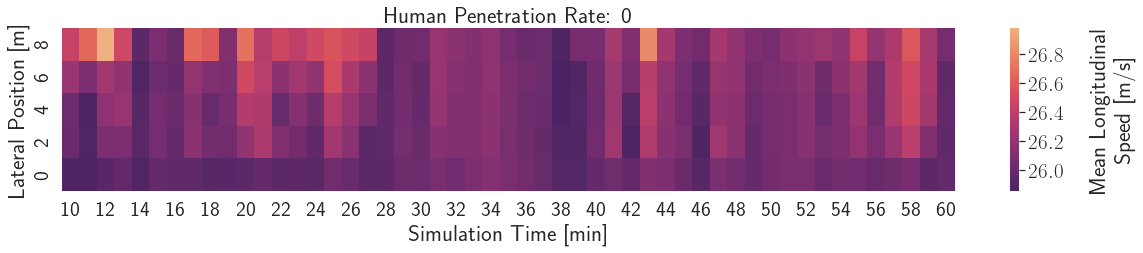

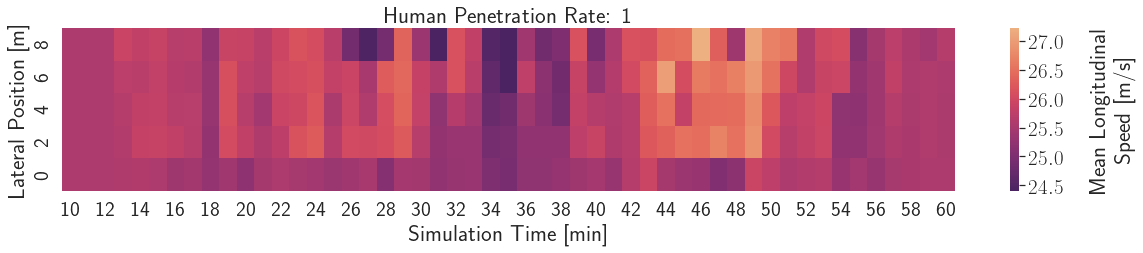

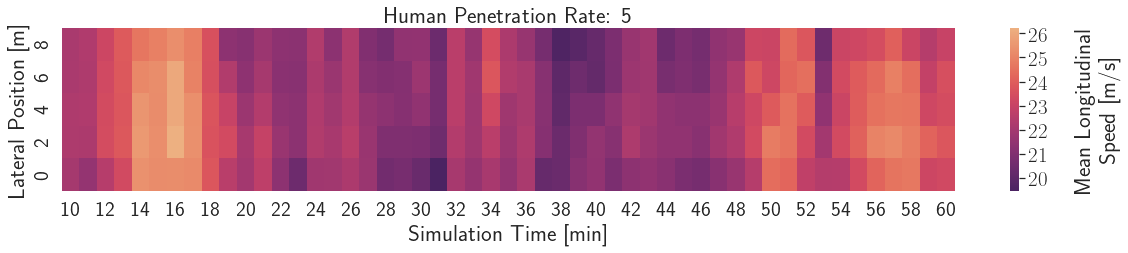

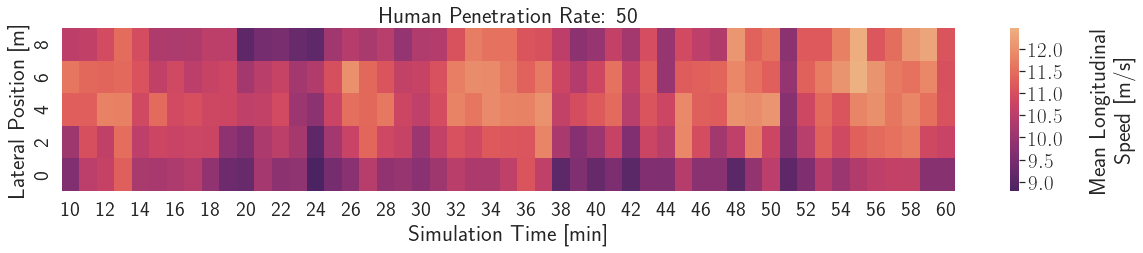

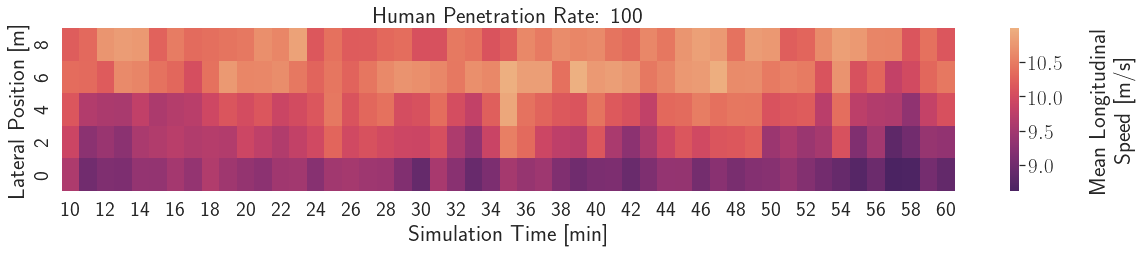

In [146]:
traj_list.sort(key=lambda x: x["Human Penetration Rate"].iloc[0])

vehile_count = 200
rates = [0, 1, 5, 50, 100]

pivot_tables = []
for traj_df in tqdm(list(traj_list)):
    if traj_df["Total Vehicles"].iloc[0] == vehile_count and traj_df["Human Penetration Rate"].iloc[0] in rates:
        ptable = traj_df.pivot_table(columns=pd.cut(traj_df["Time"] / 60, bins=range(10, 62), labels=range(10, 62)[:-1]), 
                                                  index=pd.cut(traj_df["y"], bins=np.arange(0, 10.3, 2), labels=np.arange(0, 10.3, 2)[:-1].astype(int)),
                                                  values='speed_x', aggfunc="median")
        pivot_tables.append((traj_df, ptable))
    
min_s = min([p.min().min() for _, p in pivot_tables])
max_s = max([p.max().max() for _, p in pivot_tables])
norm = matplotlib.colors.Normalize(vmin=min_s, vmax=max_s)


for traj_df, pivot_table in pivot_tables:
    rate = traj_df['Human Penetration Rate'].iloc[0]
    with sns.axes_style("whitegrid", {'axes.grid' : True}):
        with sns.plotting_context("notebook", font_scale=1.9):
            fig, ax = plt.subplots(1,1, figsize=(20,3))
            min_value = pivot_table.min().min()
            max_value = pivot_table.max().max()
            
            sns.heatmap(pivot_table, ax=ax, cmap="flare_r", cbar_kws={'label': '\nMean Longitudinal\n Speed [m/s]'})
            ax.invert_yaxis()
            ax.set_title(f"Human Penetration Rate: {rate}")
            plt.xlabel('Simulation Time [min]')
            plt.ylabel('Lateral Position [m]')
    # plt.savefig(f"trb_figures\\longitudinal_speed_heat_map_{vehile_count}_{rate}.pdf", bbox_inches='tight')

In [17]:
dplot = pd.read_pickle("trb_figures\\mixed_df_1_new.pkl")
dplot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 0 to 380
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           288 non-null    int64  
 1   Penetration Rate                288 non-null    float64
 2   Total Vehicles                  288 non-null    int64  
 3   Strip Change Threshold          264 non-null    float64
 4   seed                            288 non-null    int64  
 5   Total Humans                    288 non-null    int64  
 6   Total AV                        288 non-null    int64  
 7   scenario_name                   288 non-null    object 
 8   flow                            288 non-null    float64
 9   speed                           288 non-null    float64
 10  Mean Strip Changes              288 non-null    float64
 11  Total Collisions                288 non-null    int64  
 12  Mean Strip Changes per Vehicle  288 

In [26]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

scene_df = dplot[(dplot["Total Vehicles"].isin([50, 250])) & (dplot["Human Penetration Rate"].isin([0, 1, 5, 10, 50, 90, 100])) 
              & (dplot["Strip Change Threshold"].isin([np.nan, 10]))]

traj_list = []
speeds = []
for _, row in tqdm(list(scene_df.iterrows())):
    traj_df, _ = get_trajectory_df(row["zip_file"], row["scenario_name"])
    df = traj_df[traj_df["Time"] > 30*60]
    df_sum = df.groupby(pd.cut(df["y"], bins=np.arange(-2, 10.3, 1), labels=np.arange(-2, 10.3, 1)[:-1]).astype(int))["speed_x"].sum()
    df_count = df.groupby(pd.cut(df["y"], bins=np.arange(-2, 10.3, 1), labels=np.arange(-2, 10.3, 1)[:-1].astype(int)))["speed_x"].count()
    speed_df = (df_sum.rolling(3).sum() / df_count.rolling(3).sum()).reset_index()
    speed_df["Total Vehicles"] = row["Total Vehicles"]
    speed_df["Human Penetration Rate"] = row["Human Penetration Rate"]
    speed_df["seed"] = row["seed"]
    speeds.append(speed_df)
        
speeds = pd.concat(speeds).reset_index()
speeds

100%|██████████| 42/42 [02:01<00:00,  2.89s/it]


,index,y,speed_x,Total Vehicles,Human Penetration Rate,seed
0,0,-2,NaN,50,90,1
1,1,-1,NaN,50,90,1
2,2,0,NaN,50,90,1
3,3,1,NaN,50,90,1
4,4,2,25.607030,50,90,1
...,...,...,...,...,...,...
499,7,5,7.713629,250,100,3
500,8,6,8.240527,250,100,3
501,9,7,8.437503,250,100,3
502,10,8,8.420802,250,100,3


In [18]:
# speeds.to_pickle("trb_figures\\speed_df.pkl")
speeds = pd.read_pickle("trb_figures\\speed_df.pkl")

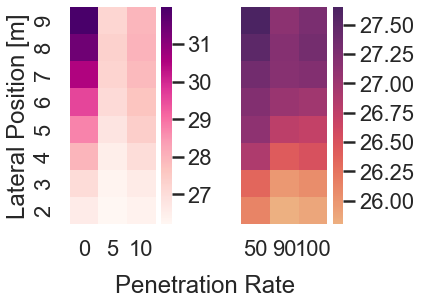

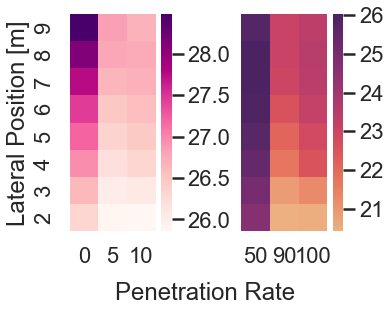

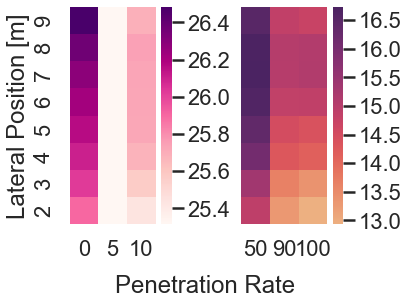

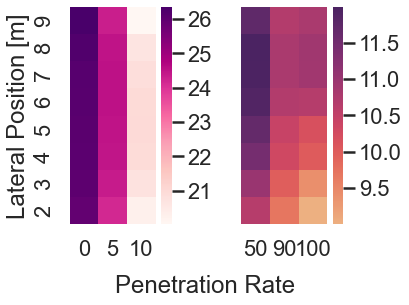

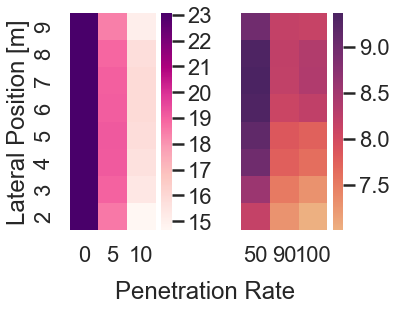

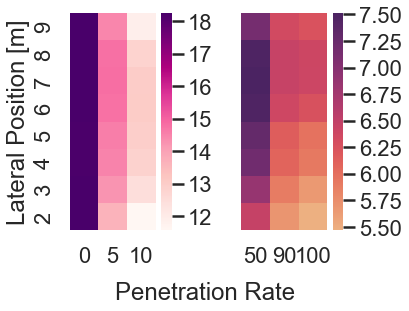

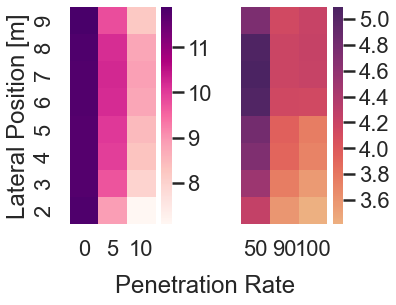

In [19]:
plot_seed = 1
pivot_tables = []
for veh, df in speeds.groupby("Total Vehicles"):
    df = df.groupby(["Human Penetration Rate", "y"]).mean().reset_index()
    # df = df[df["seed"] == plot_seed]
    with sns.axes_style("whitegrid", {'axes.grid' : True}):
        with sns.plotting_context("poster", font_scale=1):
            fig, axes = plt.subplots(1,2, figsize=(5,4), sharey=True, gridspec_kw={'width_ratios': [1, 1]})
            
            ax = axes[0]
            df_1 = df[df["Human Penetration Rate"].isin([0,5, 10])]
            df_1 = df_1.pivot_table(index="y", columns="Human Penetration Rate", values="speed_x")
            sns.heatmap(df_1, ax=ax, cmap="RdPu", #cbar_kws={'label': '\nMean Longitudinal\n Speed [m/s]'}
                        )
            ax.invert_yaxis()
            ax.set_xlabel('')
            ax.set_ylabel('Lateral Position [m]')
            
            ax = axes[1]
            df_2 = df[df["Human Penetration Rate"].isin([50, 90, 100])]
            df_2 = df_2.pivot_table(index="y", columns="Human Penetration Rate", values="speed_x")
            sns.heatmap(df_2, ax=ax, cmap="flare", #cbar_kws={'label': '\nMean Longitudinal\n Speed [m/s]'}
                        )
            ax.invert_yaxis()
            ax.set_xlabel('')
            ax.set_ylabel('')
            plt.subplots_adjust(wspace=0.6)
            plt.figtext(0.5, -0.09, f'Penetration Rate', ha='center', va='center')
            

    # plt.savefig(f"trb_figures\\longitudinal_speed_heat_map_{veh}.pdf", bbox_inches='tight')

In [218]:
fdf.min()

Human Penetration Rate
0      26.362174
1      25.700773
5      25.579073
50     26.050955
100    26.081894
dtype: float64

In [174]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

traj_list.sort(key=lambda x: x["Human Penetration Rate"].iloc[0])

speeds = []
for traj_df in tqdm(list(traj_list)):
    df = traj_df.copy()
    df["Time"] = df["Time"] / 60
    df_sum = df.groupby([pd.cut(df["Time"], bins=range(10, 62), labels=range(10, 62)[:-1]),
                         pd.cut(df["y"], bins=np.arange(-2, 10.3, 1), labels=np.arange(-2, 10.3, 1)[:-1])
                         ]
                        )["speed_x"].sum().reset_index()
    df_count = df.groupby([pd.cut(df["Time"], bins=range(10, 62), labels=range(10, 62)[:-1]),
                         pd.cut(df["y"], bins=np.arange(-2, 10.3, 1), labels=np.arange(-2, 10.3, 1)[:-1])
                         ]
                          )["speed_x"].count().reset_index()
    df_sum["count"] = df_count["speed_x"]
    df_list = []
    for time, d in df_sum.groupby("Time"):
        d["mean_speed_x"] = d["speed_x"] / d["count"]
        d["rolled_speed_x"] = d["speed_x"].rolling(3).sum() / d["count"].rolling(3).sum()
        df_list.append(d)
    speed_df = pd.concat(df_list)
    speed_df["Total Vehicles"] = df["Total Vehicles"].iloc[0]
    speed_df["Human Penetration Rate"] = df["Human Penetration Rate"].iloc[0]
    speeds.append(speed_df)
        
speeds = pd.concat(speeds).reset_index()
speeds

100%|██████████| 56/56 [01:06<00:00,  1.18s/it]


,index,Time,y,speed_x,count,mean_speed_x,rolled_speed_x,Total Vehicles,Human Penetration Rate
0,0,10,-2.0,0.000000,0,NaN,NaN,50.0,0
1,1,10,-1.0,0.000000,0,NaN,NaN,50.0,0
2,2,10,0.0,0.000000,0,NaN,NaN,50.0,0
3,3,10,1.0,27408.006500,1034,26.506776,26.506776,50.0,0
4,4,10,2.0,44491.624500,1659,26.818339,26.698712,50.0,0
...,...,...,...,...,...,...,...,...,...
34267,607,60,5.0,8523.163231,1996,4.270122,3.716267,400.0,100
34268,608,60,6.0,78716.307043,18757,4.196636,4.141596,400.0,100
34269,609,60,7.0,11214.416260,2710,4.138161,4.196134,400.0,100
34270,610,60,8.0,9054.746420,2064,4.386990,4.206599,400.0,100


100%|██████████| 56/56 [00:05<00:00,  9.80it/s]


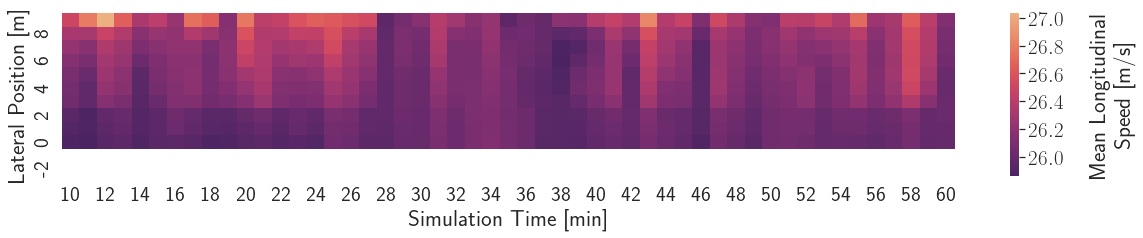

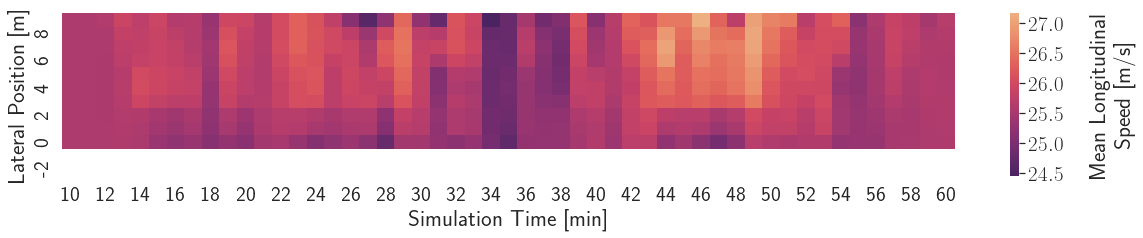

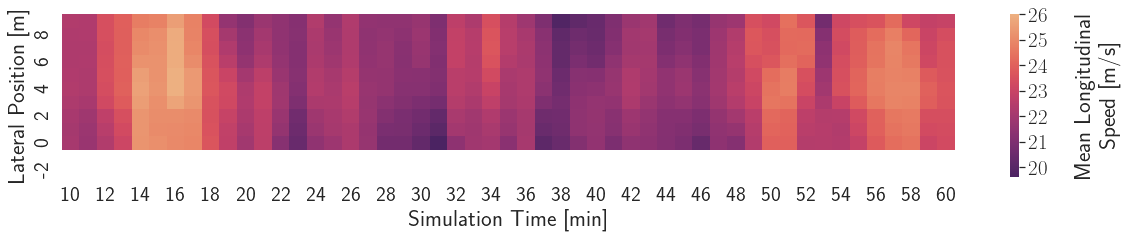

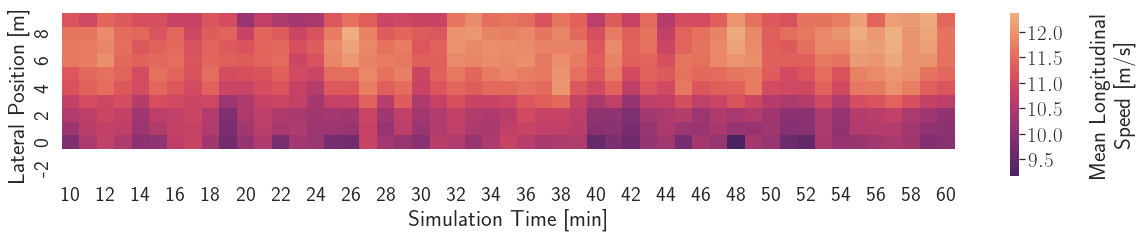

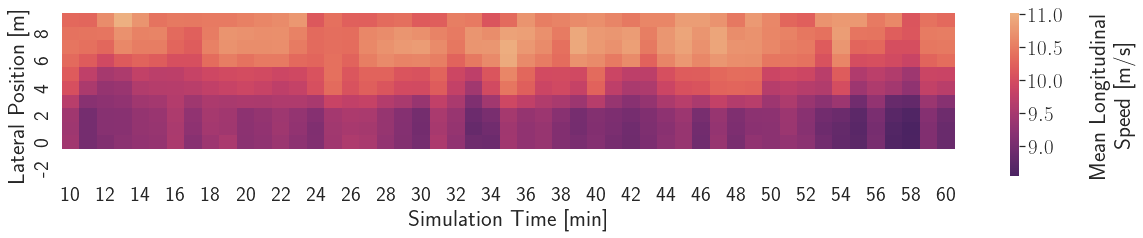

In [201]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

traj_list.sort(key=lambda x: x["Human Penetration Rate"].iloc[0])
vcount = 200
rates = [0, 1, 5, 50, 100]

speeds = []
for traj_df in tqdm(list(traj_list)):
    if traj_df["Total Vehicles"].iloc[0] != vcount or traj_df["Human Penetration Rate"].iloc[0] not in rates:
        continue
    df = traj_df.copy()
    ptable = traj_df.pivot_table(columns=pd.cut(traj_df["Time"] / 60, bins=range(10, 62), labels=range(10, 62)[:-1]), 
                                                  index=pd.cut(traj_df["y"], bins=np.arange(-2, 10.3, 1), labels=np.arange(-2, 10.3, 1)[:-1].astype(int)),
                                                  values='speed_x', aggfunc=['sum','count'])
    ptable = ptable.rolling(3).sum()
    ptable = ptable.xs('sum', axis=1, level=0).div(ptable.xs('count', axis=1, level=0))

    with sns.axes_style("whitegrid", {'axes.grid' : True}):
        with sns.plotting_context("notebook", font_scale=1.9):
            fig, ax = plt.subplots(1,1, figsize=(20,3))
            sns.heatmap(ptable, ax=ax, cmap="flare_r", cbar_kws={'label': '\nMean Longitudinal\n Speed [m/s]'})
            ax.invert_yaxis()
            # ax.set_title(f"Human Penetration Rate: }")
            plt.xlabel('Simulation Time [min]')
            plt.ylabel('Lateral Position [m]')

In [184]:
ptable

Time,10,11,12,13,14,15,16,17,18,19,...,51,52,53,54,55,56,57,58,59,60
y,,,,,,,,,,,,,,,,,,,,,
-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.359078,3.358283,3.384993,3.288071,3.331765,3.385666,3.391955,3.333056,3.405170,3.373102,...,3.331346,3.331334,3.348810,3.361500,3.383617,3.367367,3.356952,3.326732,3.329951,3.342224
2,3.365450,3.365349,3.381780,3.292794,3.341828,3.391464,3.394567,3.336243,3.403878,3.374412,...,3.334340,3.331483,3.348732,3.362461,3.388606,3.370647,3.356247,3.325202,3.333750,3.342108
3,3.496622,3.459104,3.489389,3.408646,3.398527,3.458896,3.490672,3.496654,3.509361,3.490387,...,3.550459,3.523010,3.602284,3.578853,3.534839,3.506175,3.541012,3.532497,3.523541,3.498546
4,3.664367,3.639273,3.638309,3.593682,3.503692,3.558098,3.638334,3.680697,3.655669,3.670629,...,3.753312,3.727643,3.824074,3.783880,3.693062,3.640295,3.715427,3.725311,3.724289,3.666468
5,3.684418,3.659999,3.663460,3.623938,3.525762,3.564729,3.648700,3.701737,3.678922,3.695722,...,3.815916,3.787352,3.860872,3.834016,3.740114,3.687248,3.765526,3.777590,3.771016,3.716267
6,3.969528,3.998869,3.934153,3.978834,3.995386,3.971157,3.994271,4.015025,3.972915,4.015774,...,4.347115,4.253347,4.142636,4.199223,4.190758,4.141013,4.182169,4.221226,4.211474,4.141596
7,4.097586,4.102391,4.055208,4.141202,4.213440,4.157854,4.153855,4.165768,4.097571,4.132498,...,4.432015,4.307771,4.182474,4.242074,4.248294,4.199094,4.259613,4.299909,4.295902,4.196134


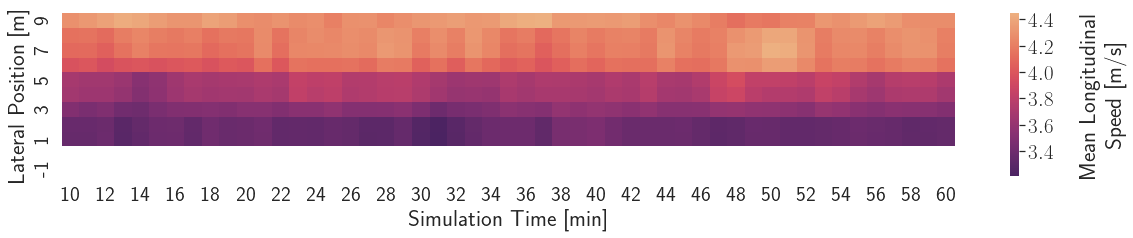

In [185]:
df = speeds[(speeds["Total Vehicles"].isin([50])) & (speeds["Human Penetration Rate"].isin([0]))]

with sns.axes_style("whitegrid", {'axes.grid' : True}):
    with sns.plotting_context("notebook", font_scale=1.9):
        fig, ax = plt.subplots(1,1, figsize=(20,3))
        pivot_table = df.pivot_table(columns="Time", index="y", values="rolled_speed_x")
        sns.heatmap(ptable, ax=ax, cmap="flare_r", cbar_kws={'label': '\nMean Longitudinal\n Speed [m/s]'})
        ax.invert_yaxis()
        # ax.set_title(f"Human Penetration Rate: }")
        plt.xlabel('Simulation Time [min]')
        plt.ylabel('Lateral Position [m]')

In [140]:
df_count

Time  y   
10    -2.0        0
      -1.0        0
      0.0      3143
      1.0     20846
      2.0      1775
              ...  
60    5.0      1996
      6.0     18757
      7.0      2710
      8.0      2064
      9.0     20633
Name: speed_x, Length: 612, dtype: int64

In [135]:
df_count.loc[9.0].reset_index()

,Time,speed_x
0,10,18240
1,11,18079
2,12,17894
3,13,18000
4,14,18266
5,15,18412
6,16,18303
7,17,18451
8,18,18593
9,19,18796


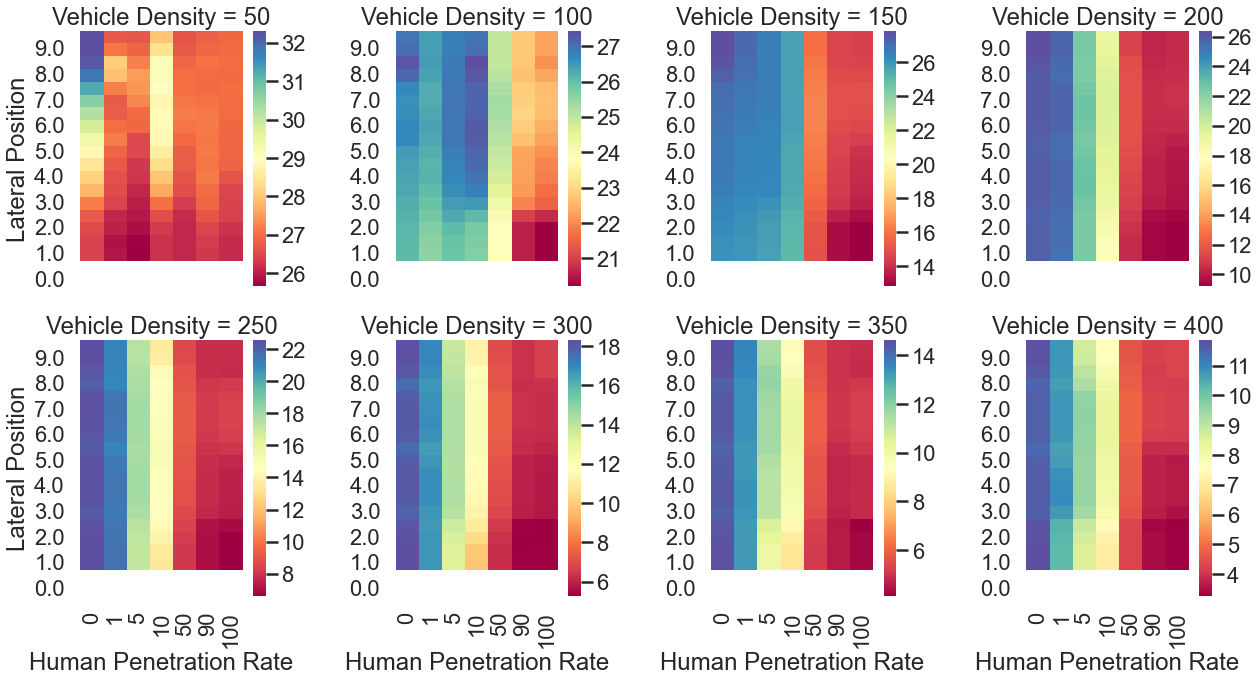

In [30]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs)
    
    
df = speeds.copy()
df["Vehicle Density"] = df["Total Vehicles"].astype(int)
df["Lateral Position"] = df["y"]
df["Mean Longitudinal Speed"] = df["speed_x"]

with sns.axes_style("whitegrid", {'axes.grid' : True}):
    with sns.plotting_context("poster", font_scale=1):
        facet = sns.FacetGrid(df, col="Vehicle Density", col_wrap=4, sharey=False, sharex=True, aspect=0.9, height=5, margin_titles=True, legend_out=True)
        facet.map_dataframe(draw_heatmap, "Human Penetration Rate", "Lateral Position", "Mean Longitudinal Speed", cmap="Spectral", 
                            )
        for ax in facet.axes.flatten():
            ax.invert_yaxis()
        plt.tight_layout()

In [152]:
traj_group_list = []
for _, row in tqdm(list(scene_df.iterrows())):
    traj_df = get_trajectory_df(row["zip_file"], row["scenario_name"])
    traj_df_grouped = traj_df.groupby([pd.cut(traj_df["Time"], bins=range(0, 4001, 60), labels=range(0, 4001, 60)[:-1]),
                                   pd.cut(traj_df["y"], bins=np.arange(0, 10.3, 1)
                                          )
                                   ])["speed_x"].mean().reset_index()
    traj_df_grouped["Human Penetration Rate"] = row["Human Penetration Rate"]
    traj_df_grouped["Total Vehicles"] = row["Total Vehicles"]
    traj_group_list.append(traj_df_grouped)
traj_group_df = pd.concat(traj_group_list)

100%|██████████| 15/15 [01:38<00:00,  6.55s/it]


In [93]:
# traj_group_df.to_pickle("trb_figures\\longitudinal_speed_df.pkl")
# traj_group_df = pd.read_pickle("trb_figures\\longitudinal_speed_df.pkl")
#traj_group_df.to_pickle("trb_figures\\longitudinal_speed_df_2.pkl")
traj_group_df = pd.read_pickle("trb_figures\\longitudinal_speed_df_2.pkl")
traj_group_df

,Time,y,speed_x,Human Penetration Rate,Total Vehicles
0,0,"(0.0, 2.0]",8.826661,50,200.0
1,0,"(2.0, 4.0]",8.298101,50,200.0
2,0,"(4.0, 6.0]",8.400310,50,200.0
3,0,"(6.0, 8.0]",8.838352,50,200.0
4,0,"(8.0, 10.0]",9.878273,50,200.0
...,...,...,...,...,...
325,3900,"(0.0, 2.0]",10.774825,1,400.0
326,3900,"(2.0, 4.0]",11.091411,1,400.0
327,3900,"(4.0, 6.0]",11.099193,1,400.0
328,3900,"(6.0, 8.0]",11.330133,1,400.0


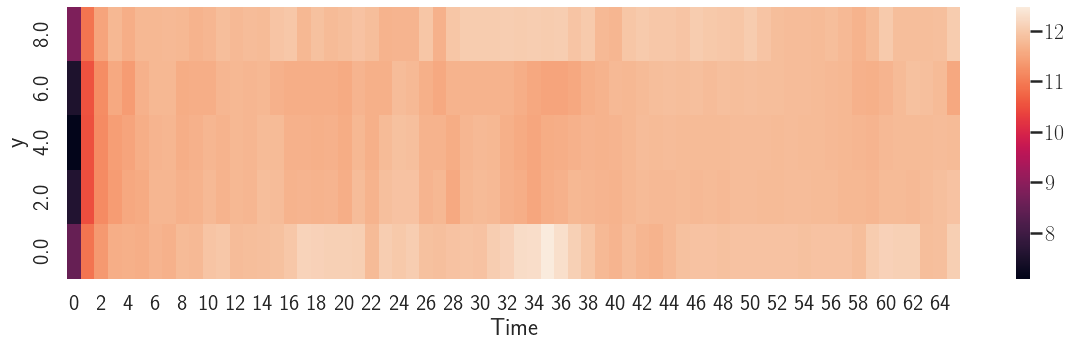

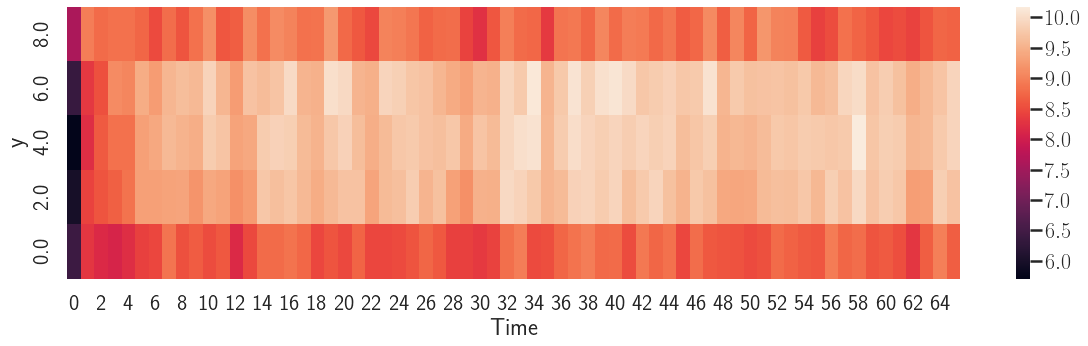

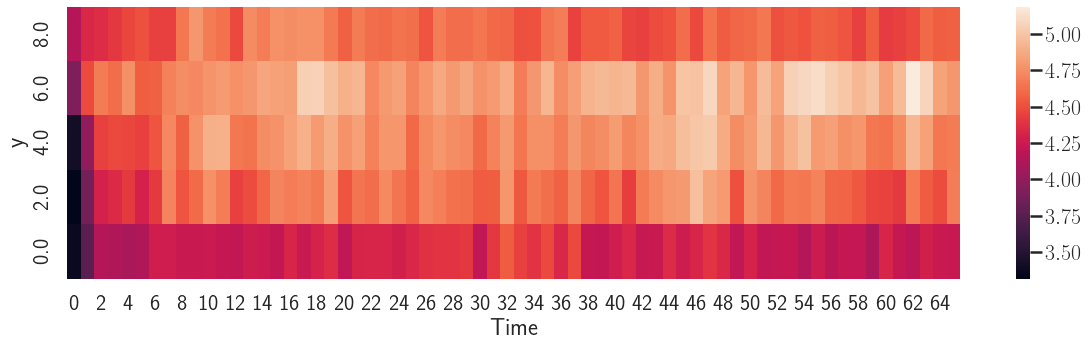

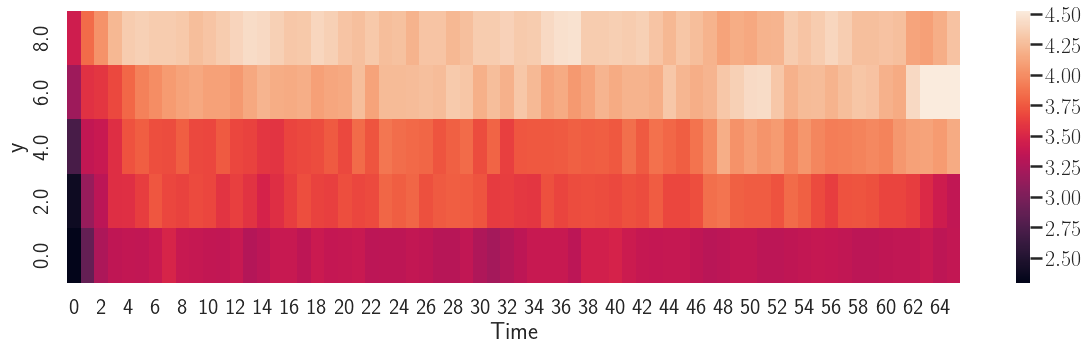

In [97]:
from operator import attrgetter
df = traj_group_df[(traj_group_df["Human Penetration Rate"].isin([0, 5, 50, 100])) & (traj_group_df["Total Vehicles"].isin([400]))].copy()
df["Time"] = (df["Time"].astype(float) / 60).astype(int)
df["y"] = df["y"].map(attrgetter('left'))

for _, d in df.groupby("Human Penetration Rate"):
    with sns.axes_style("whitegrid", {'axes.grid' : True}):
        with sns.plotting_context("poster", font_scale=1):
            fig, ax = plt.subplots(1,1, figsize=(20,5))
            sns.heatmap(d.pivot("y", "Time", "speed_x"), ax=ax)
            ax.invert_yaxis()


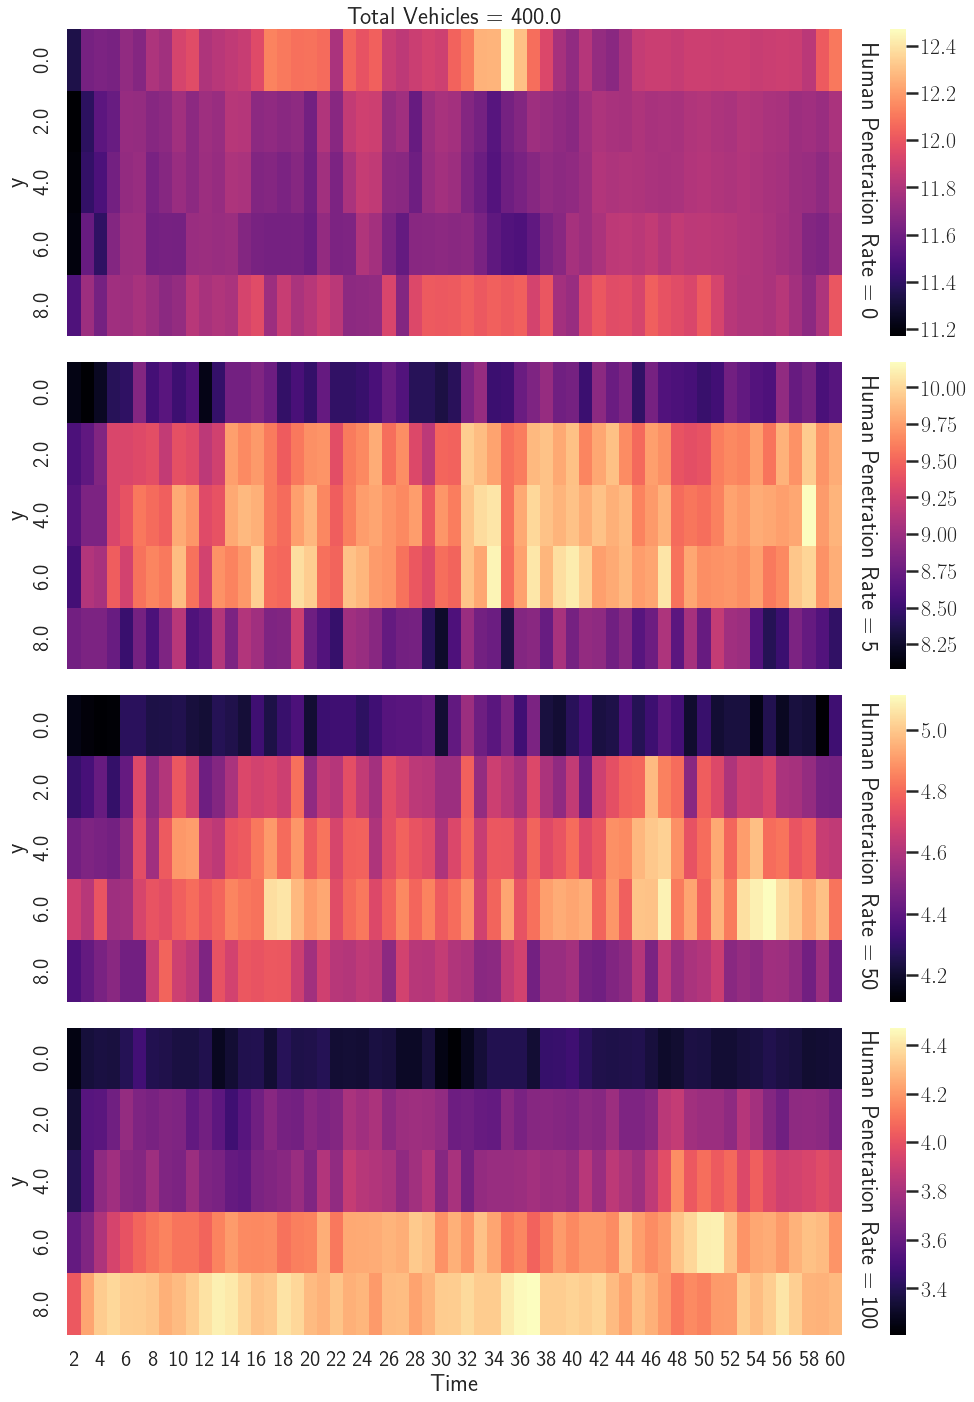

In [81]:
from operator import attrgetter

df = traj_group_df[(traj_group_df["Human Penetration Rate"].isin([0, 5, 50, 100])) & (traj_group_df["Total Vehicles"].isin([400]))].copy()
df["Time"] = (df["Time"].astype(float) / 60).astype(int)
df = df[(df["Time"] <= 60) & (df["Time"] >= 2)]
# df = df[df["Time"] <= 60]
df["y"] = df["y"].map(attrgetter('left'))

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs)

with sns.axes_style("whitegrid", {'axes.grid' : True}):
    with sns.plotting_context("poster", font_scale=1):
        facet = sns.FacetGrid(df, col="Total Vehicles", row="Human Penetration Rate",  sharey=True, sharex=True, aspect=3, height=5, margin_titles=True, legend_out=True)
        
        # norm = matplotlib.colors.LogNorm(vmin=df["speed_x"].min(), vmax=df["speed_x"].max())
        facet.map_dataframe(draw_heatmap, "Time", "y", "speed_x", cmap="magma", 
                            )
        #facet.set(ylim=(df["y"].min(), df["y"].max()))
        # facet.set_titles(col_template = "")
        # for ax in facet.axes.flatten():
        # #     ax.set_ylabel(col, labelpad=11)
        #     ax.invert_yaxis()

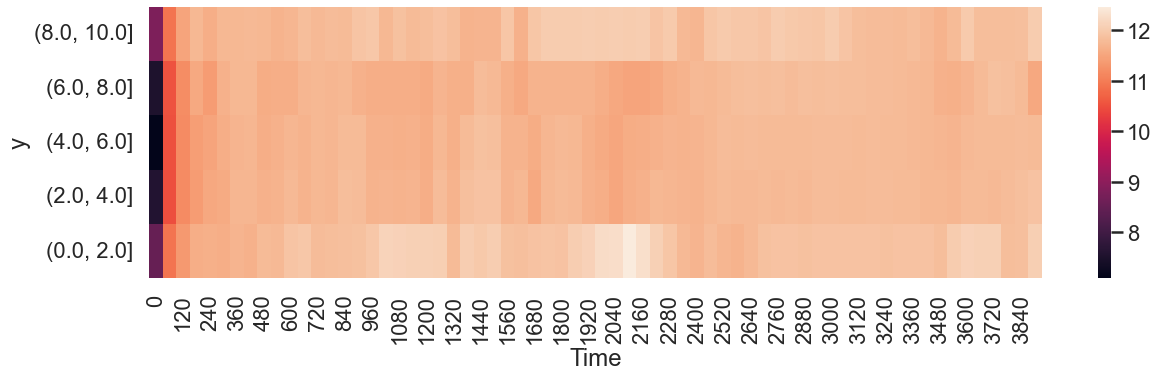

In [105]:
# Plot traj_df_grouped as a heatmap with Time on x-axis and y on y-axis
with sns.axes_style("whitegrid", {'axes.grid' : True}):
    with sns.plotting_context("poster", font_scale=1):
        fig, ax = plt.subplots(1,1, figsize=(20,5))
        sns.heatmap(traj_df_grouped.pivot("y", "Time", "speed_x"), ax=ax)
        ax.invert_yaxis()

## Gap to Potential Lines

In [60]:
dplot = pd.read_pickle("trb_figures\\mixed_df_1_new.pkl")
dplot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 0 to 380
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           288 non-null    int64  
 1   Penetration Rate                288 non-null    float64
 2   Total Vehicles                  288 non-null    int64  
 3   Strip Change Threshold          264 non-null    float64
 4   seed                            288 non-null    int64  
 5   Total Humans                    288 non-null    int64  
 6   Total AV                        288 non-null    int64  
 7   scenario_name                   288 non-null    object 
 8   flow                            288 non-null    float64
 9   speed                           288 non-null    float64
 10  Mean Strip Changes              288 non-null    float64
 11  Total Collisions                288 non-null    int64  
 12  Mean Strip Changes per Vehicle  288 

In [61]:
def calculate_PL_gap(tj_df, vinfo):
    lower_long = 1.2
    upper_long = 9.0
    min_desired = 25
    max_desired = 35
    area = max_desired - min_desired
    vinfo["PL"] = lower_long + (upper_long - lower_long) * (vinfo["desired_speed"] - min_desired) / area
    
    tj_df = tj_df[tj_df["Time"] > (4000 - 20*60)]
    
    mean_diff = tj_df[tj_df["Vehicle1"].apply(lambda x: "AV" in x)].copy()
    mean_diff["PL"] = vinfo.set_index("Vehicle").loc[mean_diff["Vehicle1"].values]["PL"].values
    mean_diff["pl_error"] = mean_diff["PL"] - mean_diff["y"]
    mean_diff["mean_pl_error"] = mean_diff["pl_error"].abs()
    mean_diff = mean_diff.groupby("Vehicle1")["mean_pl_error"].agg(['mean', 'std']).reset_index()
    mean_diff = mean_diff.set_index("Vehicle1")
    
    mean_df = tj_df.groupby("Vehicle1")["y"].agg(['mean', 'std']).reset_index()
    mean_df["PL"] = vinfo.set_index("Vehicle").loc[mean_df["Vehicle1"].values]["PL"].values
    mean_df["pl_gap_to_mean"] = mean_df["PL"] - mean_df["mean"]
    mean_df = mean_df.set_index("Vehicle1")
    mean_df["mean_pl_gap_to_mean"] = mean_diff["mean"]
    mean_df["mean_pl_gap_to_std"] = mean_diff["std"]
    
    return mean_df

In [62]:
v_count = [50, 100, 150, 200, 300, 400]
human_rate = [0, 1, 5, 50]
df_list = []

sce_df = dplot[(dplot["Total Vehicles"].isin(v_count)) & (dplot["Human Penetration Rate"].isin(human_rate))]

for _, row in tqdm(list(sce_df.iterrows())):
    tj_df, vinfo = get_trajectory_df(row["zip_file"], row["scenario_name"])
    mean_gap = calculate_PL_gap(tj_df, vinfo)
    mean_gap["Total Vehicles"] = row["Total Vehicles"]
    mean_gap["Human Penetration Rate"] = row["Human Penetration Rate"]
    mean_gap["seed"] = row["seed"]
    df_list.append(mean_gap)
pl_gap_df = pd.concat(df_list).reset_index()

100%|██████████| 72/72 [05:25<00:00,  4.53s/it]


In [63]:
# pl_gap_df.to_pickle("trb_figures\\pl_gap_df.pkl")

In [58]:
# pl_gap_df = pd.read_pickle("trb_figures\\pl_gap_df.pkl")

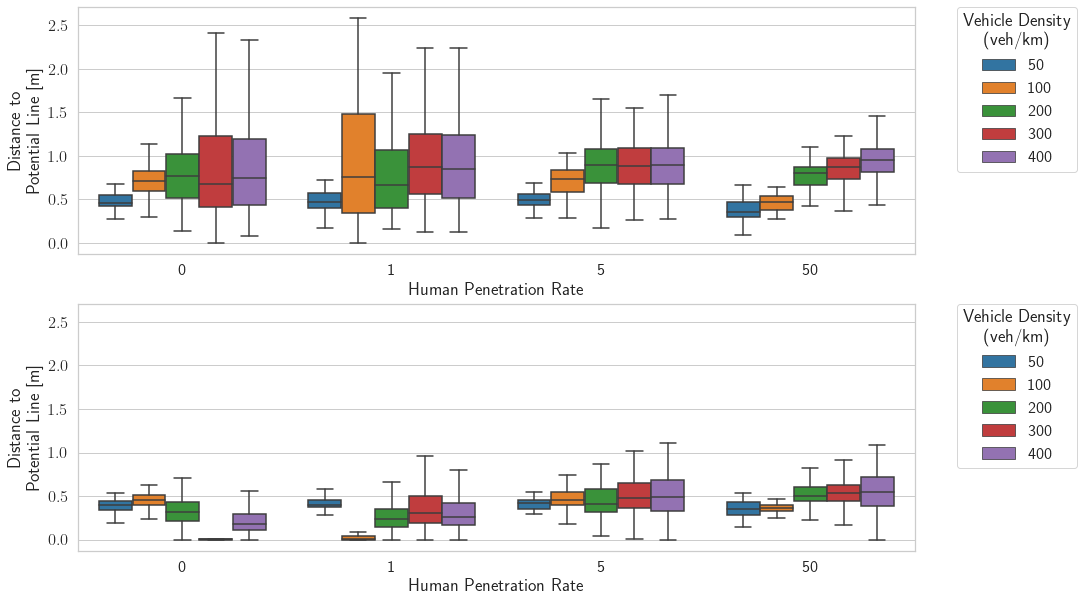

In [82]:
df = pl_gap_df[pl_gap_df["Vehicle1"].apply(lambda x: "AV" in x)].copy()
df = df[df["Total Vehicles"].isin([50, 100, 200, 300, 400])]
df = df[df["seed"] == 2]

with sns.axes_style("whitegrid", {'axes.grid' : True}):
    with sns.plotting_context("notebook", font_scale=1.5):
        fig, axes = plt.subplots(2,1, figsize=(15,10), sharey=True)
        
        ax = axes[0]
        sns.boxplot(data=df, x="Human Penetration Rate", y="mean_pl_gap_to_mean", hue="Total Vehicles", showfliers=False, ax=ax)
        l = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="Vehicle Density\n(veh/km)")
        l.get_title().set_multialignment('center')
        ax.set_ylabel("Distance to\n Potential Line [m]")
        
        ax = axes[1]
        sns.boxplot(data=df, x="Human Penetration Rate", y="mean_pl_gap_to_std", hue="Total Vehicles", showfliers=False, ax=ax)
        l = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="Vehicle Density\n(veh/km)")
        l.get_title().set_multialignment('center')
        ax.set_ylabel("Distance to\n Potential Line [m]")

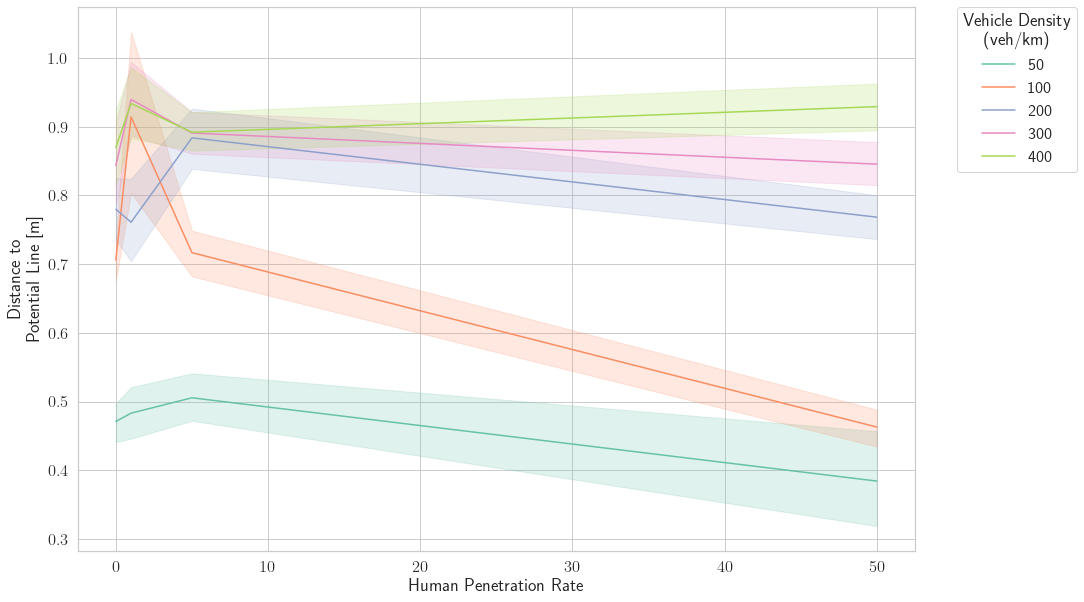

In [143]:
df = pl_gap_df[pl_gap_df["Vehicle1"].apply(lambda x: "AV" in x)].copy()
df = df[df["Total Vehicles"].isin([50, 100, 200, 300, 400])]
df = df[df["seed"] == 2]

with sns.axes_style("whitegrid", {'axes.grid' : True}):
    with sns.plotting_context("notebook", font_scale=1.5):
        fig, ax = plt.subplots(1,1, figsize=(15,10))
        sns.lineplot(data=df, x="Human Penetration Rate", y="mean_pl_gap_to_mean", hue="Total Vehicles", ax=ax, palette="Set2")
        l = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="Vehicle Density\n(veh/km)")
        l.get_title().set_multialignment('center')
        ax.set_ylabel("Distance to\n Potential Line [m]")

In [72]:
df = pl_gap_df[pl_gap_df["Vehicle1"].apply(lambda x: "AV" in x)].copy()
df = df[df["Total Vehicles"].isin([50, 100, 200, 300, 400])]
df = df[df["seed"] == 2]

with sns.axes_style("whitegrid", {'axes.grid' : True}):
    with sns.plotting_context("poster", font_scale=1):
        custom_palette = sns.color_palette("husl", 6)
        d = {'color': custom_palette}
        
        facet = sns.FacetGrid(facet_data, col="variable", col_wrap=3, sharey=False, sharex=False, aspect=1.2, height=5, margin_titles=True, 
                              legend_out=True, xlim=(-5,105)  #hue_kws=d, hue="Vehicle Density (veh/km)", xlim=(-0.5, 100),
                             )
        facet.map_dataframe(sns.lineplot, "Human Penetration Rate", "value", hue="Vehicle Density (veh/km)", 
                            style="Vehicle Density (veh/km)", markers=True, palette=custom_palette, markersize=10
                            )
        facet.set_titles(col_template = "")
        for ax, col in zip(facet.axes.flatten(), plot_vars):
            ax.set_ylabel(col, labelpad=11)
        plt.tight_layout()
        facet.add_legend(title="Vehicle Density (veh/km)", ncol=6, bbox_to_anchor=(0.55, 1.1))
        plt.setp(facet._legend.get_title(), ha='center')

,Vehicle1,mean,std,PL,PL_gap,Total Vehicles,Human Penetration Rate,seed
0,AV_1_0,9.355327,0.109597,8.978004,-0.377323,50,50,1
1,AV_1_1,8.147712,0.752259,8.473968,0.326256,50,50,1
2,AV_1_2,1.727157,0.364781,2.199336,0.472179,50,50,1
3,AV_1_3,9.282393,0.162656,8.992512,-0.289881,50,50,1
4,AV_1_4,3.067553,0.483579,3.041502,-0.026051,50,50,1
...,...,...,...,...,...,...,...,...
395,AV_7_77,4.369858,0.001182,4.874346,0.504488,400,0,3
396,AV_7_78,0.940000,0.000000,1.544136,0.604136,400,0,3
397,AV_7_79,3.790717,0.005197,5.196876,1.406159,400,0,3
398,AV_7_8,9.260000,0.000000,7.048596,-2.211404,400,0,3


## Space Time Plot

In [13]:
dplot = pd.read_pickle("trb_figures\\mixed_df_1_new.pkl")
dplot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 0 to 380
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           288 non-null    int64  
 1   Penetration Rate                288 non-null    float64
 2   Total Vehicles                  288 non-null    int64  
 3   Strip Change Threshold          264 non-null    float64
 4   seed                            288 non-null    int64  
 5   Total Humans                    288 non-null    int64  
 6   Total AV                        288 non-null    int64  
 7   scenario_name                   288 non-null    object 
 8   flow                            288 non-null    float64
 9   speed                           288 non-null    float64
 10  Mean Strip Changes              288 non-null    float64
 11  Total Collisions                288 non-null    int64  
 12  Mean Strip Changes per Vehicle  288 

In [14]:
v_count = [400]
human_rate = [100]  
seed = 1

sce_df = dplot[(dplot["Total Vehicles"].isin(v_count)) & (dplot["Human Penetration Rate"].isin(human_rate)) & (dplot["seed"] == seed)]
tj_list = []
for _, row in tqdm(list(sce_df.iterrows())):
    tj_df, vinfo = get_trajectory_df(row["zip_file"], row["scenario_name"])
    tj_df['x_diff'] = tj_df.groupby('Vehicle1')['x'].diff()
    tj_df['rotation_flag'] = tj_df['x_diff'] < 0
    tj_df['rounds_of_rotation'] = tj_df.groupby('Vehicle1')['rotation_flag'].cumsum()
    tj_df['x_corrected'] = tj_df['rounds_of_rotation']*1000 + tj_df['x']
    tj_df["Total Vehicles"] = row["Total Vehicles"]
    tj_df["Human Penetration Rate"] = row["Human Penetration Rate"]
    tj_list.append(tj_df)
tj_df = pd.concat(tj_list)
del tj_list


100%|██████████| 1/1 [00:17<00:00, 17.90s/it]


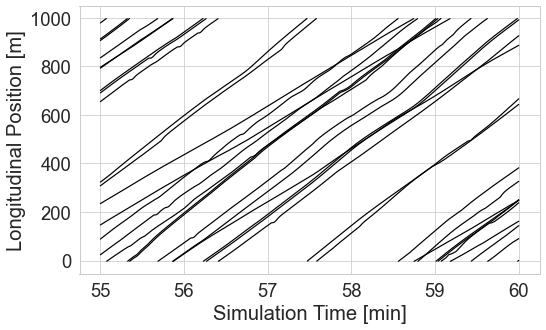

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Copy the dataframe
for veh_count in [400]:
    for rate in [100]:
        df = tj_df[(tj_df["Total Vehicles"] == veh_count) & (tj_df["Human Penetration Rate"] == rate)].copy()
        # Identify autonomous vehicles
        df["is_AV"] = df["Vehicle1"].apply(lambda x: "AV" in x)
        vehicles = df[df["is_AV"] == False]["Vehicle1"].unique()
        
        # Filter the dataframe
        df = df[(df["Time"] > 55*60) & (df["Time"] <= 60*60)]
        df["Time min"] = df["Time"] / 60
        df = df[df["Vehicle1"].isin(vehicles[:15])]
        df["VID"] = df["Vehicle1"] + df["rounds_of_rotation"].astype(str)
        
        # Identify traffic waves (example threshold values)
        speed_threshold = 10  # Adjust this value based on your data
        df["traffic_wave"] = df["speed_x"].abs() < speed_threshold 
        
        # Plot the data
        with sns.axes_style("whitegrid", {'axes.grid': True}):
            with sns.plotting_context("paper", font_scale=2.1):
                fig, ax = plt.subplots(1, 1, figsize=(8, 5))
                
                # Plot all lines in black
                sns.lineplot(data=df, x="Time min", y="x", ax=ax, hue="VID", palette=["black"]*len(df["VID"].unique()), legend=None)
                
                # # Highlight traffic waves in red
                # traffic_wave_df = df[df["traffic_wave"] == True]
                # for vid in traffic_wave_df["VID"].unique():
                #     sns.lineplot(data=traffic_wave_df[traffic_wave_df["VID"] == vid], x="Time", y="x", ax=ax, color='red', legend=None)
                
                ax.set_ylabel("Longitudinal Position [m]")
                ax.set_xlabel("Simulation Time [min]")
                plt.tight_layout()
        # plt.savefig(f"trb_figures\\space_time_plot_{veh_count}_{rate}.pdf", bbox_inches='tight')

C:\Users\ga96rum\AppData\Local\Temp\ipykernel_40240\3710278700.py:37: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(sm, ax=ax)


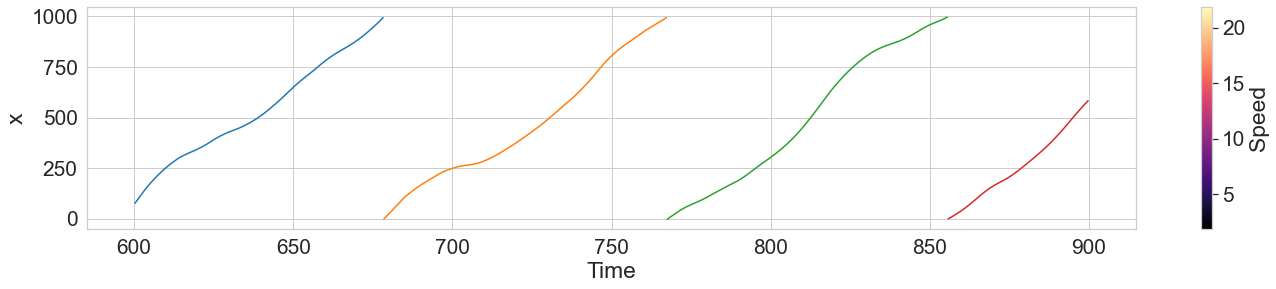

In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Copy the dataframe
df = tj_df.copy()

# Identify autonomous vehicles
df["is_AV"] = df["Vehicle1"].apply(lambda x: "AV" in x)
vehicles = df[df["is_AV"] == True]["Vehicle1"].unique()

# Filter the dataframe
df = df[(df["Time"] > 10*60) & (df["Time"] < 15*60)]
df = df[df["Vehicle1"].isin(vehicles[:1])]
df["VID"] = df["Vehicle1"] + df["rounds_of_rotation"].astype(str)

# Identify traffic waves (example threshold values)
speed_threshold = 10  # Adjust this value based on your data
df["traffic_wave"] = df["speed_x"].abs() < speed_threshold 

# Create a color palette based on speed
norm = plt.Normalize(df["speed_x"].min(), df["speed_x"].max())
sm = plt.cm.ScalarMappable(cmap="magma", norm=norm)
df["color"] = df["speed_x"].apply(lambda x: sm.to_rgba(x))

# Plot the data
with sns.axes_style("whitegrid", {'axes.grid': True}):
    with sns.plotting_context("notebook", font_scale=1.9):
        fig, ax = plt.subplots(1, 1, figsize=(20, 4.5))
        
        # Plot lines with color based on speed
        for vid in df["VID"].unique():
            subset = df[df["VID"] == vid]
            sns.lineplot(data=subset, x="Time", y="x", ax=ax, palette=subset["color"].values, legend=None)
        
        # Add color bar
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Speed')

        plt.tight_layout()
        plt.show()


In [87]:
df

,Time,Vehicle1,x,y,speed_x,speed_y,acceleration_x,acceleration_y,x_diff,rotation_flag,rounds_of_rotation,x_corrected,is_AV,VID,traffic_wave,color
600000,600.25,AV_1_0,75.59,9.30,20.67,-0.02,0.69,-0.01,5.14,False,7,7075.59,True,AV_1_07,False,"(0.99244, 0.88433, 0.640099, 1.0)"
600250,600.50,AV_1_0,80.78,9.29,20.84,-0.02,0.69,-0.01,5.19,False,7,7080.78,True,AV_1_07,False,"(0.991688, 0.898627, 0.654202, 1.0)"
600500,600.75,AV_1_0,86.01,9.29,21.01,-0.02,0.69,-0.01,5.23,False,7,7086.01,True,AV_1_07,False,"(0.99057, 0.920049, 0.675675, 1.0)"
600750,601.00,AV_1_0,91.29,9.28,21.18,-0.02,0.68,-0.01,5.28,False,7,7091.29,True,AV_1_07,False,"(0.989815, 0.934329, 0.690198, 1.0)"
601000,601.25,AV_1_0,96.60,9.28,21.35,-0.02,0.68,-0.01,5.31,False,7,7096.60,True,AV_1_07,False,"(0.989077, 0.948604, 0.704863, 1.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898500,898.75,AV_1_0,567.41,9.40,16.38,0.00,-0.91,0.00,4.12,False,10,10567.41,True,AV_1_010,False,"(0.97821, 0.483612, 0.366025, 1.0)"
898750,899.00,AV_1_0,571.48,9.40,16.15,0.00,-0.90,0.00,4.07,False,10,10571.48,True,AV_1_010,False,"(0.975082, 0.468861, 0.363111, 1.0)"
899000,899.25,AV_1_0,575.49,9.40,15.93,0.00,-0.88,0.00,4.01,False,10,10575.49,True,AV_1_010,False,"(0.96968, 0.446936, 0.360311, 1.0)"
899250,899.50,AV_1_0,579.44,9.40,15.71,0.00,-0.86,0.00,3.95,False,10,10579.44,True,AV_1_010,False,"(0.96331, 0.42539, 0.359469, 1.0)"
